# Learning a quadratic prior

This code attempts to learn a concave quadratic prior $J(x) = -\frac{1}{4}||x||_2^2$ in the context of a Hamilton-Jacobi PDE with a quadratic Hamiltonian $H(p) = \frac{1}{2}||p||_2^2$.
The LPN learns the function $\psi(x) = ||x||_2^2$.

## Import modules 

In [1]:
import os
import numpy as np
import torch

import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator
import seaborn as sns

from network import LPN
from lib.utils import cvx
from lib.invert import invert

# set location
MODEL_DIR = "experiments/models/concave_quadratic_prior_64D"
os.makedirs(MODEL_DIR, exist_ok=True)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# set random seeds
np.random.seed(1)
torch.manual_seed(1)

# plotting options
plt.rcParams.update({"text.usetex": False})
sns.set_theme()

## Parameters

In [2]:
# Parameters
# --- Parameters fof Experiment ---
dim_exp = 64  # Dimension (e.g., 2D, 4D, 8D as in the paper)
data_points_exp = 40000 # Example number of data points
iterations_exp_initial = 1 # Iterations for initial training phase
iterations_exp_long = 500000 # Iterations for longer training phase
a_exp = 4 # Grid limit for sampling y_j if using uniform, e.g., y_j in [-a, a]^d
spacing = 50 # For plotting cross-sections


# LPN model parameters
# Note: The defaults parameters are beta = 10, hidden = 50, layers = 4
beta = 10       # beta of softplus
hidden = 50     # number of hidden units
layers = 4      # number of layers
eps = 0.5
# optimization algorithm to use for computing the prior (cvx_cg, cvx_gd)
INVERT_MODE = "cvx_gd"

# === Section ===

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import torch 

# === Section 4.1.2: L1 Prior Helper Functions ===

def inner_prod(x, y):
    return np.sum(x * y, axis=1)

def euclid_norm_sq(x):
    if x.ndim == 1:
        return np.sum(x*x)
    return np.sum(x * x, axis=1)


def cvx_true_concave_quad(y_points): # y_points is N x dim
    """
    Computes the target function psi(y) = ||y||_2^2 for the given problem.
    """
    return euclid_norm_sq(y_points)

def prior_true_concave_quad(x_points):
    """
    Computes the true concave prior J(x) = -1/4 * ||x||_2^2.
    """
    return -0.25 * euclid_norm_sq(x_points)

def invert_prior_lpn(x, model, INVERT_MODE):
    y = invert(x,model,INVERT_MODE)
    return y

def evaluate_learned_prior_lpn(x_eval_points, y_inverted_points, model):
    try:
        y_tensor = torch.from_numpy(y_inverted_points).float().to(device)
        psi_of_y_inverted = model.scalar(y_tensor).squeeze(1).detach().cpu().numpy()
    except NameError: 
        print("Warning: 'device' not defined. Assuming CPU for evaluate_learned_prior.")
        y_tensor = torch.from_numpy(y_inverted_points).float()
        psi_of_y_inverted = model.scalar(y_tensor).squeeze(1).detach().numpy()
    prior_est = inner_prod(x_eval_points, y_inverted_points) - 0.5 * euclid_norm_sq(x_eval_points) - psi_of_y_inverted
    return prior_est


def compute_square_cross_sections(a, spacing, dim):
    xi = np.linspace(-a, a, spacing)
    grid = np.zeros((xi.size, dim))
    x1_0_points = np.copy(grid)
    x1_0_points[:, 0] = xi
    x2_0_points = np.copy(grid)
    if dim > 1:
        x2_0_points[:, 1] = xi
    elif dim == 1:
        x2_0_points = x1_0_points.copy()
    return xi, x1_0_points, x2_0_points

def cross_sections_plots_concave_quad(model, a, spacing, INVERT_MODE, dim):
    xi, x1_0_points, x2_0_points = compute_square_cross_sections(a, spacing, dim)
    
    x1_0_psi_true = cvx_true_concave_quad(x1_0_points)
    x1_0_J_true = prior_true_concave_quad(x1_0_points)
    if dim > 1:
        x2_0_psi_true = cvx_true_concave_quad(x2_0_points)
        x2_0_J_true = prior_true_concave_quad(x2_0_points)
    else: 
        x2_0_psi_true = x1_0_psi_true 
        x2_0_J_true = x1_0_J_true
        
    x1_0_psi_est = cvx(x1_0_points, model) 
    y1_inverted = invert_prior_lpn(x1_0_points, model, INVERT_MODE)
    x1_0_J_est = evaluate_learned_prior_lpn(x1_0_points,y1_inverted, model)
    if dim > 1:
        x2_0_psi_est = cvx(x2_0_points, model)
        y2_inverted = invert_prior_lpn(x2_0_points, model, INVERT_MODE)
        x2_0_J_est = evaluate_learned_prior_lpn(x2_0_points,y2_inverted, model)
    else:
        x2_0_psi_est = x1_0_psi_est
        x2_0_J_est = x1_0_J_est
        
    plt.figure(figsize=(12,5))
    plt.subplot(1, 2, 1)
    plt.plot(xi, x1_0_psi_est, "-", ms=5, label="LPN (Learned $\\psi$)")
    plt.plot(xi, x1_0_psi_true, "--", ms=5, label="True $\\psi$ for $J(x)=\\|x\\|_1$")
    plt.grid(True)
    plt.title(f"$\\psi(y_1,0,...)$ - Dim {dim}, $J(x)=\\|x\\|_1$")
    plt.xlabel('$y_1$')
    plt.ylabel('$\\psi(y_1,0,...)$')
    plt.legend()

    if dim > 1:
        plt.subplot(1, 2, 2) # Second plot for psi if dim > 1
        plt.plot(xi, x2_0_psi_est, "-", ms=5, label="LPN (Learned $\\psi$)")
        plt.plot(xi, x2_0_psi_true, "--", ms=5, label="True $\\psi$ for $J(x)=-1/4\\|x\\|_2^2$")
        plt.grid(True)
        plt.title(f"$\\psi(0,y_2,0,...)$ - Dim {dim}, $J(x)=-1/4\\|x\\|_2^2$")
        plt.xlabel('$y_2$')
        plt.ylabel('$\\psi(0,y_2,0,...)$')
        plt.legend()
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(12,5))
    plt.subplot(1, 2, 1)
    plt.plot(xi, x1_0_J_est, "-", label="LPN (Learned $J$)")
    plt.plot(xi, x1_0_J_true, "--", label="True $J(x)=-1/4\\|x\\|_2^2$")
    plt.grid(True)
    plt.title(f"Prior $J(x_1,0,...)$ - Dim {dim}, $J(x)=-1/4\\|x\\|_2^2$")
    plt.xlabel('$x_1$')
    plt.ylabel('$J(x_1,0,...)$')
    plt.legend()

    if dim > 1:
        plt.subplot(1, 2, 2)
        plt.plot(xi, x2_0_J_est, "-", label="LPN (Learned $J$)")
        plt.plot(xi, x2_0_J_true, "--", label="True $J(x)=-1/4\\|x\\|_2^2$")
        plt.grid(True)
        plt.title(f"Prior $J(0,x_2,0,...)$ - Dim {dim}, $J(x)=-1/4\\|x\\|_2^2$")
        plt.xlabel('$x_2$')
        plt.ylabel('$J(0,x_2,0,...)$')
        plt.legend()
    plt.tight_layout()
    plt.show()

def plot_all_concave_quad(model, a, spacing, INVERT_MODE, dim):
    print(f"\n--- Plotting Cross Sections for Quadratic H, Quadratic concave Prior (Dim={dim}) ---")
    cross_sections_plots_concave_quad(model, a, spacing, INVERT_MODE, dim)



In [4]:
def evaluate_learned_H(model, a, spacing, dim):
    """
    Calculates and plots the approximate Hamiltonian H_theta.
    H_theta(p) = max_k { <p, eta_k> - b_k }
    where eta_k = x_k - grad_psi(x_k) and b_k = 0.5 * ||eta_k||^2
    """
    x_k_np = np.random.uniform(-a, a, (data_points_exp, dim))
    x_k_tensor = torch.from_numpy(x_k_np).float().to(device)
    x_k_tensor.requires_grad_(True)
    grad_psi_k_tensor = model(x_k_tensor)

    eta_k_tensor = x_k_tensor - grad_psi_k_tensor
    b_k_tensor = 0.5 * torch.sum(eta_k_tensor**2, dim=1, keepdim=True)

    xi = np.linspace(-a, a, spacing)
    p_eval_points_np = np.zeros((xi.size, dim))
    p_eval_points_np[:, 0] = xi
    p_eval_tensor = torch.from_numpy(p_eval_points_np).float().to(device)

    # Compute H_theta(p) for the cross-section
    inner_prods = torch.matmul(p_eval_tensor, eta_k_tensor.T)  # (spacing x data_points)
    H_theta_p_tensor = torch.max(inner_prods - b_k_tensor.T, dim=1, keepdim=True)[0]
    H_theta_p_np = H_theta_p_tensor.detach().cpu().numpy().flatten()

    # Compute true Hamiltonian H(p) = 0.5 * ||p||^2
    H_true_p_np = 0.5 * euclid_norm_sq(p_eval_points_np)

    plt.figure(figsize=(6,5))
    plt.plot(xi, H_theta_p_np, "-", label="Learned Hamiltonian $H_{\\theta}(p_1,0,...)$")
    plt.plot(xi, H_true_p_np, "--", label="True Hamiltonian $H(p)=1/2||p||_2^2$")
    plt.grid(True)
    plt.title(f"Hamiltonian Comparison - Dim {dim}")
    plt.xlabel('$p_1$')
    plt.ylabel('H(p)')
    plt.legend()
    plt.tight_layout()
    plt.show()


# --- Generate Training Data

In [5]:
# --- Generate Training Data for the new experiment ---
print("--- Generating Training Data for Concave Quadratic Prior ---")
y_j_exp_np = np.random.uniform(-a_exp, a_exp, (data_points_exp, dim_exp))
psi_samples_exp_np = cvx_true_concave_quad(y_j_exp_np)
psi_samples_exp_np = psi_samples_exp_np.reshape(-1, 1)

y_j_exp_tensor = torch.from_numpy(y_j_exp_np).float().to(device)
psi_samples_exp_tensor = torch.from_numpy(psi_samples_exp_np).float().to(device)
print(f"Generated training data: y_j_exp_tensor shape {y_j_exp_tensor.shape}, psi_samples_exp_tensor shape {psi_samples_exp_tensor.shape}")

# --- ADD THIS TO MOVE DATA TO GPU ---
y_j_exp_tensor = y_j_exp_tensor.to(device)
psi_samples_exp_tensor = psi_samples_exp_tensor.to(device)

--- Generating Training Data for Concave Quadratic Prior ---


Generated training data: y_j_exp_tensor shape torch.Size([40000, 64]), psi_samples_exp_tensor shape torch.Size([40000, 1])


## Training function

In [6]:
def single_iteration(i, data_points, lpn_model, optimizer,input,cvx_samples,loss_type, gamma_loss=None):
    # Compute the convex function from the input.
    cvx_out = lpn_model.scalar(input)

    # Calculate the loss function
    if loss_type == 2:
        loss = (cvx_out - cvx_samples).pow(2).sum() / data_points # MSE loss
    elif loss_type == 1:
        loss = (cvx_out - cvx_samples).abs().sum() / data_points    # MAE loss
    #elif loss_type == 0:
    #    loss = exp_func(cvx_out - cvx_samples, gamma_loss).mean()   # proximal matching loss
    else:
        raise ValueError("loss_type must be 0, 1, or 2")


    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    lpn_model.wclip()

    # monitor
    # loss_lstar = exp_func(out - target, 0.1).mean()

    if not i % 500:
        print("iteration", i, "loss", loss.item()) #, "loss_lstar", loss_lstar.item())

# Train

L2 loss -- Train

In [7]:

# --- Train and Plot with L2 Loss for the new experiment ---
print("\n--- Training LPN for Concave Quadratic Prior (Quadratic H) ---")
lpn_model_concave_quad_l2 = LPN(in_dim=dim_exp, hidden=hidden, layers=layers, beta=beta,eps=1e-3).to(device)
optimizer_concave_quad = torch.optim.Adam(lpn_model_concave_quad_l2.parameters(), lr=1e-4)

# Initial shorter training phase with a higher learning rate
for i in range(1):
     single_iteration(i, data_points_exp, lpn_model_concave_quad_l2, optimizer_concave_quad, y_j_exp_tensor, psi_samples_exp_tensor, loss_type=2, gamma_loss=None)

# Longer training phase with a reduced learning rate
for g in optimizer_concave_quad.param_groups:
    g["lr"] = 1e-4
for i in range(iterations_exp_long):
    if (i % 20000 == 0) and (i > 0): 
        # Multiply the current learning rate by 1e-1
        for g in optimizer_concave_quad.param_groups:
            new_lr = g["lr"] * 1e-1
            g["lr"] = new_lr
        print(f"Learning rate decreased to {new_lr} at iteration {i}")    
    single_iteration(i, data_points_exp, lpn_model_concave_quad_l2, optimizer_concave_quad, y_j_exp_tensor, psi_samples_exp_tensor, loss_type=2, gamma_loss=None)

torch.save(lpn_model_concave_quad_l2.state_dict(), os.path.join(MODEL_DIR, "ConcaveQuadraticH_l2.pth"))



--- Training LPN for Concave Quadratic Prior (Quadratic H) ---


iteration 0 loss 117948.8515625
iteration 0 loss 109965.8203125


iteration 500 loss 1287.438232421875


iteration 1000 loss 1024.3441162109375


iteration 1500 loss 828.6517944335938


iteration 2000 loss 686.656494140625


iteration 2500 loss 582.7685546875


iteration 3000 loss 508.3242492675781


iteration 3500 loss 456.0546875


iteration 4000 loss 419.3810119628906


iteration 4500 loss 392.160888671875


iteration 5000 loss 370.1992492675781


iteration 5500 loss 350.85504150390625


iteration 6000 loss 332.9510803222656


iteration 6500 loss 315.70819091796875


iteration 7000 loss 298.568603515625


iteration 7500 loss 281.02374267578125


iteration 8000 loss 262.1647644042969


iteration 8500 loss 241.98509216308594


iteration 9000 loss 219.74972534179688


iteration 9500 loss 191.85256958007812


iteration 10000 loss 152.09922790527344


iteration 10500 loss 103.3359375


iteration 11000 loss 73.84990692138672


iteration 11500 loss 60.56769943237305


iteration 12000 loss 53.747718811035156


iteration 12500 loss 49.34850311279297


iteration 13000 loss 46.32167053222656


iteration 13500 loss 44.29633712768555


iteration 14000 loss 42.685760498046875


iteration 14500 loss 41.36853790283203


iteration 15000 loss 40.33259582519531


iteration 15500 loss 39.44204330444336


iteration 16000 loss 38.606388092041016


iteration 16500 loss 37.84286880493164


iteration 17000 loss 37.2287483215332


iteration 17500 loss 36.656070709228516


iteration 18000 loss 36.14665603637695


iteration 18500 loss 35.697750091552734


iteration 19000 loss 35.28776550292969


iteration 19500 loss 34.90824890136719


Learning rate decreased to 1e-05 at iteration 20000
iteration 20000 loss 34.55937957763672


iteration 20500 loss 34.52191925048828


iteration 21000 loss 34.47446823120117


iteration 21500 loss 34.41478729248047


iteration 22000 loss 34.33992385864258


iteration 22500 loss 34.24644470214844


iteration 23000 loss 34.13081359863281


iteration 23500 loss 33.98954391479492


iteration 24000 loss 33.819278717041016


iteration 24500 loss 33.61848831176758


iteration 25000 loss 33.391117095947266


iteration 25500 loss 33.156986236572266


iteration 26000 loss 32.92500686645508


iteration 26500 loss 32.69296646118164


iteration 27000 loss 32.46085739135742


iteration 27500 loss 32.22465515136719


iteration 28000 loss 31.985742568969727


iteration 28500 loss 31.742965698242188


iteration 29000 loss 31.498815536499023


iteration 29500 loss 31.250699996948242


iteration 30000 loss 30.997642517089844


iteration 30500 loss 30.74013900756836


iteration 31000 loss 30.481281280517578


iteration 31500 loss 30.21901512145996


iteration 32000 loss 29.952329635620117


iteration 32500 loss 29.679101943969727


iteration 33000 loss 29.399349212646484


iteration 33500 loss 29.112518310546875


iteration 34000 loss 28.818649291992188


iteration 34500 loss 28.515155792236328


iteration 35000 loss 28.199155807495117


iteration 35500 loss 27.87067413330078


iteration 36000 loss 27.533464431762695


iteration 36500 loss 27.180896759033203


iteration 37000 loss 26.81703758239746


iteration 37500 loss 26.439577102661133


iteration 38000 loss 26.049699783325195


iteration 38500 loss 25.649202346801758


iteration 39000 loss 25.234643936157227


iteration 39500 loss 24.80818748474121


Learning rate decreased to 1.0000000000000002e-06 at iteration 40000
iteration 40000 loss 24.366973876953125


iteration 40500 loss 24.3178768157959


iteration 41000 loss 24.26051902770996


iteration 41500 loss 24.194887161254883


iteration 42000 loss 24.121723175048828


iteration 42500 loss 24.04231071472168


iteration 43000 loss 23.958261489868164


iteration 43500 loss 23.871158599853516


iteration 44000 loss 23.782323837280273


iteration 44500 loss 23.692720413208008


iteration 45000 loss 23.603221893310547


iteration 45500 loss 23.514652252197266


iteration 46000 loss 23.42683982849121


iteration 46500 loss 23.339584350585938


iteration 47000 loss 23.252758026123047


iteration 47500 loss 23.166276931762695


iteration 48000 loss 23.080059051513672


iteration 48500 loss 22.994037628173828


iteration 49000 loss 22.90814971923828


iteration 49500 loss 22.822301864624023


iteration 50000 loss 22.736465454101562


iteration 50500 loss 22.650571823120117


iteration 51000 loss 22.56454086303711


iteration 51500 loss 22.478330612182617


iteration 52000 loss 22.391965866088867


iteration 52500 loss 22.30541229248047


iteration 53000 loss 22.218595504760742


iteration 53500 loss 22.131546020507812


iteration 54000 loss 22.044198989868164


iteration 54500 loss 21.95652198791504


iteration 55000 loss 21.868520736694336


iteration 55500 loss 21.78017807006836


iteration 56000 loss 21.691421508789062


iteration 56500 loss 21.602252960205078


iteration 57000 loss 21.51266098022461


iteration 57500 loss 21.42264175415039


iteration 58000 loss 21.332111358642578


iteration 58500 loss 21.24111557006836


iteration 59000 loss 21.149658203125


iteration 59500 loss 21.057722091674805


Learning rate decreased to 1.0000000000000002e-07 at iteration 60000
iteration 60000 loss 20.965255737304688


iteration 60500 loss 20.955883026123047


iteration 61000 loss 20.946361541748047


iteration 61500 loss 20.936721801757812


iteration 62000 loss 20.926992416381836


iteration 62500 loss 20.9172306060791


iteration 63000 loss 20.907455444335938


iteration 63500 loss 20.897687911987305


iteration 64000 loss 20.8879337310791


iteration 64500 loss 20.87820053100586


iteration 65000 loss 20.868488311767578


iteration 65500 loss 20.858806610107422


iteration 66000 loss 20.849153518676758


iteration 66500 loss 20.839521408081055


iteration 67000 loss 20.829904556274414


iteration 67500 loss 20.820302963256836


iteration 68000 loss 20.810705184936523


iteration 68500 loss 20.80112075805664


iteration 69000 loss 20.79154396057129


iteration 69500 loss 20.78197479248047


iteration 70000 loss 20.772411346435547


iteration 70500 loss 20.76285171508789


iteration 71000 loss 20.753299713134766


iteration 71500 loss 20.743745803833008


iteration 72000 loss 20.734193801879883


iteration 72500 loss 20.724639892578125


iteration 73000 loss 20.7150936126709


iteration 73500 loss 20.70553970336914


iteration 74000 loss 20.695987701416016


iteration 74500 loss 20.68643569946289


iteration 75000 loss 20.6768798828125


iteration 75500 loss 20.66732406616211


iteration 76000 loss 20.657772064208984


iteration 76500 loss 20.648212432861328


iteration 77000 loss 20.638648986816406


iteration 77500 loss 20.629093170166016


iteration 78000 loss 20.61952781677246


iteration 78500 loss 20.60996437072754


iteration 79000 loss 20.60039710998535


iteration 79500 loss 20.590824127197266


Learning rate decreased to 1.0000000000000004e-08 at iteration 80000
iteration 80000 loss 20.581254959106445


iteration 80500 loss 20.5803279876709


iteration 81000 loss 20.57939910888672


iteration 81500 loss 20.578468322753906


iteration 82000 loss 20.57754135131836


iteration 82500 loss 20.576614379882812


iteration 83000 loss 20.575685501098633


iteration 83500 loss 20.574758529663086


iteration 84000 loss 20.57383155822754


iteration 84500 loss 20.572906494140625


iteration 85000 loss 20.571977615356445


iteration 85500 loss 20.571048736572266


iteration 86000 loss 20.57012367248535


iteration 86500 loss 20.569198608398438


iteration 87000 loss 20.56827163696289


iteration 87500 loss 20.567346572875977


iteration 88000 loss 20.566421508789062


iteration 88500 loss 20.56549644470215


iteration 89000 loss 20.5645751953125


iteration 89500 loss 20.56364631652832


iteration 90000 loss 20.562725067138672


iteration 90500 loss 20.561800003051758


iteration 91000 loss 20.560874938964844


iteration 91500 loss 20.559951782226562


iteration 92000 loss 20.55902671813965


iteration 92500 loss 20.558103561401367


iteration 93000 loss 20.557180404663086


iteration 93500 loss 20.556255340576172


iteration 94000 loss 20.555335998535156


iteration 94500 loss 20.554412841796875


iteration 95000 loss 20.55348777770996


iteration 95500 loss 20.55256462097168


iteration 96000 loss 20.55164337158203


iteration 96500 loss 20.550718307495117


iteration 97000 loss 20.54979705810547


iteration 97500 loss 20.548871994018555


iteration 98000 loss 20.547948837280273


iteration 98500 loss 20.547029495239258


iteration 99000 loss 20.54610824584961


iteration 99500 loss 20.54518699645996


Learning rate decreased to 1.0000000000000005e-09 at iteration 100000
iteration 100000 loss 20.54426383972168


iteration 100500 loss 20.54425048828125


iteration 101000 loss 20.544240951538086


iteration 101500 loss 20.544231414794922


iteration 102000 loss 20.544218063354492


iteration 102500 loss 20.544206619262695


iteration 103000 loss 20.54419708251953


iteration 103500 loss 20.544189453125


iteration 104000 loss 20.54417610168457


iteration 104500 loss 20.544166564941406


iteration 105000 loss 20.54415512084961


iteration 105500 loss 20.54414176940918


iteration 106000 loss 20.54413414001465


iteration 106500 loss 20.544124603271484


iteration 107000 loss 20.544109344482422


iteration 107500 loss 20.544099807739258


iteration 108000 loss 20.54408836364746


iteration 108500 loss 20.544076919555664


iteration 109000 loss 20.544065475463867


iteration 109500 loss 20.54405975341797


iteration 110000 loss 20.54404640197754


iteration 110500 loss 20.544036865234375


iteration 111000 loss 20.54402732849121


iteration 111500 loss 20.54401397705078


iteration 112000 loss 20.544004440307617


iteration 112500 loss 20.543991088867188


iteration 113000 loss 20.543983459472656


iteration 113500 loss 20.543970108032227


iteration 114000 loss 20.543960571289062


iteration 114500 loss 20.543949127197266


iteration 115000 loss 20.54393768310547


iteration 115500 loss 20.543926239013672


iteration 116000 loss 20.543916702270508


iteration 116500 loss 20.54390525817871


iteration 117000 loss 20.543895721435547


iteration 117500 loss 20.54388427734375


iteration 118000 loss 20.543874740600586


iteration 118500 loss 20.54386329650879


iteration 119000 loss 20.543851852416992


iteration 119500 loss 20.543842315673828


Learning rate decreased to 1.0000000000000006e-10 at iteration 120000
iteration 120000 loss 20.543832778930664


iteration 120500 loss 20.543832778930664


iteration 121000 loss 20.54383087158203


iteration 121500 loss 20.54383087158203


iteration 122000 loss 20.54383087158203


iteration 122500 loss 20.54383087158203


iteration 123000 loss 20.54383087158203


iteration 123500 loss 20.54383087158203


iteration 124000 loss 20.543832778930664


iteration 124500 loss 20.54383087158203


iteration 125000 loss 20.543834686279297


iteration 125500 loss 20.54383087158203


iteration 126000 loss 20.543832778930664


iteration 126500 loss 20.543832778930664


iteration 127000 loss 20.54383087158203


iteration 127500 loss 20.543832778930664


iteration 128000 loss 20.543832778930664


iteration 128500 loss 20.54383087158203


iteration 129000 loss 20.543832778930664


iteration 129500 loss 20.543832778930664


iteration 130000 loss 20.543832778930664


iteration 130500 loss 20.543834686279297


iteration 131000 loss 20.543832778930664


iteration 131500 loss 20.543832778930664


iteration 132000 loss 20.543834686279297


iteration 132500 loss 20.543834686279297


iteration 133000 loss 20.543832778930664


iteration 133500 loss 20.543834686279297


iteration 134000 loss 20.543834686279297


iteration 134500 loss 20.543834686279297


iteration 135000 loss 20.543834686279297


iteration 135500 loss 20.543834686279297


iteration 136000 loss 20.543834686279297


iteration 136500 loss 20.543834686279297


iteration 137000 loss 20.543834686279297


iteration 137500 loss 20.543834686279297


iteration 138000 loss 20.543834686279297


iteration 138500 loss 20.543834686279297


iteration 139000 loss 20.543834686279297


iteration 139500 loss 20.543834686279297


Learning rate decreased to 1.0000000000000006e-11 at iteration 140000
iteration 140000 loss 20.543834686279297


iteration 140500 loss 20.543834686279297


iteration 141000 loss 20.543834686279297


iteration 141500 loss 20.543834686279297


iteration 142000 loss 20.543834686279297


iteration 142500 loss 20.543834686279297


iteration 143000 loss 20.543834686279297


iteration 143500 loss 20.543834686279297


iteration 144000 loss 20.543832778930664


iteration 144500 loss 20.543834686279297


iteration 145000 loss 20.543834686279297


iteration 145500 loss 20.543834686279297


iteration 146000 loss 20.543832778930664


iteration 146500 loss 20.54383087158203


iteration 147000 loss 20.54383087158203


iteration 147500 loss 20.543832778930664


iteration 148000 loss 20.543834686279297


iteration 148500 loss 20.543832778930664


iteration 149000 loss 20.543832778930664


iteration 149500 loss 20.543832778930664


iteration 150000 loss 20.543834686279297


iteration 150500 loss 20.54383087158203


iteration 151000 loss 20.543832778930664


iteration 151500 loss 20.54383087158203


iteration 152000 loss 20.54383087158203


iteration 152500 loss 20.543832778930664


iteration 153000 loss 20.543834686279297


iteration 153500 loss 20.543834686279297


iteration 154000 loss 20.543834686279297


iteration 154500 loss 20.543832778930664


iteration 155000 loss 20.543834686279297


iteration 155500 loss 20.543834686279297


iteration 156000 loss 20.543834686279297


iteration 156500 loss 20.543832778930664


iteration 157000 loss 20.543834686279297


iteration 157500 loss 20.543834686279297


iteration 158000 loss 20.543834686279297


iteration 158500 loss 20.543834686279297


iteration 159000 loss 20.54383087158203


iteration 159500 loss 20.543834686279297


Learning rate decreased to 1.0000000000000006e-12 at iteration 160000
iteration 160000 loss 20.543832778930664


iteration 160500 loss 20.54383087158203


iteration 161000 loss 20.54383087158203


iteration 161500 loss 20.54383087158203


iteration 162000 loss 20.543832778930664


iteration 162500 loss 20.543832778930664


iteration 163000 loss 20.543832778930664


iteration 163500 loss 20.543832778930664


iteration 164000 loss 20.543832778930664


iteration 164500 loss 20.543832778930664


iteration 165000 loss 20.543832778930664


iteration 165500 loss 20.543832778930664


iteration 166000 loss 20.543832778930664


iteration 166500 loss 20.543832778930664


iteration 167000 loss 20.543832778930664


iteration 167500 loss 20.543832778930664


iteration 168000 loss 20.543832778930664


iteration 168500 loss 20.543832778930664


iteration 169000 loss 20.543832778930664


iteration 169500 loss 20.543832778930664


iteration 170000 loss 20.543832778930664


iteration 170500 loss 20.543832778930664


iteration 171000 loss 20.543832778930664


iteration 171500 loss 20.543832778930664


iteration 172000 loss 20.543832778930664


iteration 172500 loss 20.543832778930664


iteration 173000 loss 20.543832778930664


iteration 173500 loss 20.543832778930664


iteration 174000 loss 20.543832778930664


iteration 174500 loss 20.543832778930664


iteration 175000 loss 20.543832778930664


iteration 175500 loss 20.543832778930664


iteration 176000 loss 20.543832778930664


iteration 176500 loss 20.543832778930664


iteration 177000 loss 20.543832778930664


iteration 177500 loss 20.543832778930664


iteration 178000 loss 20.543832778930664


iteration 178500 loss 20.543832778930664


iteration 179000 loss 20.543832778930664


iteration 179500 loss 20.543832778930664


Learning rate decreased to 1.0000000000000007e-13 at iteration 180000
iteration 180000 loss 20.543832778930664


iteration 180500 loss 20.543832778930664


iteration 181000 loss 20.543832778930664


iteration 181500 loss 20.543832778930664


iteration 182000 loss 20.543832778930664


iteration 182500 loss 20.543832778930664


iteration 183000 loss 20.543832778930664


iteration 183500 loss 20.543832778930664


iteration 184000 loss 20.543832778930664


iteration 184500 loss 20.543832778930664


iteration 185000 loss 20.543832778930664


iteration 185500 loss 20.543832778930664


iteration 186000 loss 20.543832778930664


iteration 186500 loss 20.543832778930664


iteration 187000 loss 20.543832778930664


iteration 187500 loss 20.543832778930664


iteration 188000 loss 20.543832778930664


iteration 188500 loss 20.543832778930664


iteration 189000 loss 20.543832778930664


iteration 189500 loss 20.543832778930664


iteration 190000 loss 20.543832778930664


iteration 190500 loss 20.543832778930664


iteration 191000 loss 20.543832778930664


iteration 191500 loss 20.543832778930664


iteration 192000 loss 20.543832778930664


iteration 192500 loss 20.543832778930664


iteration 193000 loss 20.543832778930664


iteration 193500 loss 20.543832778930664


iteration 194000 loss 20.543832778930664


iteration 194500 loss 20.543832778930664


iteration 195000 loss 20.543832778930664


iteration 195500 loss 20.543832778930664


iteration 196000 loss 20.543832778930664


iteration 196500 loss 20.543832778930664


iteration 197000 loss 20.543832778930664


iteration 197500 loss 20.543832778930664


iteration 198000 loss 20.543832778930664


iteration 198500 loss 20.543832778930664


iteration 199000 loss 20.543832778930664


iteration 199500 loss 20.543832778930664


Learning rate decreased to 1.0000000000000008e-14 at iteration 200000
iteration 200000 loss 20.543832778930664


iteration 200500 loss 20.543832778930664


iteration 201000 loss 20.543832778930664


iteration 201500 loss 20.543832778930664


iteration 202000 loss 20.543832778930664


iteration 202500 loss 20.543832778930664


iteration 203000 loss 20.543832778930664


iteration 203500 loss 20.543832778930664


iteration 204000 loss 20.543832778930664


iteration 204500 loss 20.543832778930664


iteration 205000 loss 20.543832778930664


iteration 205500 loss 20.543832778930664


iteration 206000 loss 20.543832778930664


iteration 206500 loss 20.543832778930664


iteration 207000 loss 20.543832778930664


iteration 207500 loss 20.543832778930664


iteration 208000 loss 20.543832778930664


iteration 208500 loss 20.543832778930664


iteration 209000 loss 20.543832778930664


iteration 209500 loss 20.543832778930664


iteration 210000 loss 20.543832778930664


iteration 210500 loss 20.543832778930664


iteration 211000 loss 20.543832778930664


iteration 211500 loss 20.543832778930664


iteration 212000 loss 20.543832778930664


iteration 212500 loss 20.543832778930664


iteration 213000 loss 20.543832778930664


iteration 213500 loss 20.543832778930664


iteration 214000 loss 20.543832778930664


iteration 214500 loss 20.543832778930664


iteration 215000 loss 20.543832778930664


iteration 215500 loss 20.543832778930664


iteration 216000 loss 20.543832778930664


iteration 216500 loss 20.543832778930664


iteration 217000 loss 20.543832778930664


iteration 217500 loss 20.543832778930664


iteration 218000 loss 20.543832778930664


iteration 218500 loss 20.543832778930664


iteration 219000 loss 20.543832778930664


iteration 219500 loss 20.543832778930664


Learning rate decreased to 1.0000000000000009e-15 at iteration 220000
iteration 220000 loss 20.543832778930664


iteration 220500 loss 20.543832778930664


iteration 221000 loss 20.543832778930664


iteration 221500 loss 20.543832778930664


iteration 222000 loss 20.543832778930664


iteration 222500 loss 20.543832778930664


iteration 223000 loss 20.543832778930664


iteration 223500 loss 20.543832778930664


iteration 224000 loss 20.543832778930664


iteration 224500 loss 20.543832778930664


iteration 225000 loss 20.543832778930664


iteration 225500 loss 20.543832778930664


iteration 226000 loss 20.543832778930664


iteration 226500 loss 20.543832778930664


iteration 227000 loss 20.543832778930664


iteration 227500 loss 20.543832778930664


iteration 228000 loss 20.543832778930664


iteration 228500 loss 20.543832778930664


iteration 229000 loss 20.543832778930664


iteration 229500 loss 20.543832778930664


iteration 230000 loss 20.543832778930664


iteration 230500 loss 20.543832778930664


iteration 231000 loss 20.543832778930664


iteration 231500 loss 20.543832778930664


iteration 232000 loss 20.543832778930664


iteration 232500 loss 20.543832778930664


iteration 233000 loss 20.543832778930664


iteration 233500 loss 20.543832778930664


iteration 234000 loss 20.543832778930664


iteration 234500 loss 20.543832778930664


iteration 235000 loss 20.543832778930664


iteration 235500 loss 20.543832778930664


iteration 236000 loss 20.543832778930664


iteration 236500 loss 20.543832778930664


iteration 237000 loss 20.543832778930664


iteration 237500 loss 20.543832778930664


iteration 238000 loss 20.543832778930664


iteration 238500 loss 20.543832778930664


iteration 239000 loss 20.543832778930664


iteration 239500 loss 20.543832778930664


Learning rate decreased to 1.000000000000001e-16 at iteration 240000
iteration 240000 loss 20.543832778930664


iteration 240500 loss 20.543832778930664


iteration 241000 loss 20.543832778930664


iteration 241500 loss 20.543832778930664


iteration 242000 loss 20.543832778930664


iteration 242500 loss 20.543832778930664


iteration 243000 loss 20.543832778930664


iteration 243500 loss 20.543832778930664


iteration 244000 loss 20.543832778930664


iteration 244500 loss 20.543832778930664


iteration 245000 loss 20.543832778930664


iteration 245500 loss 20.543832778930664


iteration 246000 loss 20.543832778930664


iteration 246500 loss 20.543832778930664


iteration 247000 loss 20.543832778930664


iteration 247500 loss 20.543832778930664


iteration 248000 loss 20.543832778930664


iteration 248500 loss 20.543832778930664


iteration 249000 loss 20.543832778930664


iteration 249500 loss 20.543832778930664


iteration 250000 loss 20.543832778930664


iteration 250500 loss 20.543832778930664


iteration 251000 loss 20.543832778930664


iteration 251500 loss 20.543832778930664


iteration 252000 loss 20.543832778930664


iteration 252500 loss 20.543832778930664


iteration 253000 loss 20.543832778930664


iteration 253500 loss 20.543832778930664


iteration 254000 loss 20.543832778930664


iteration 254500 loss 20.543832778930664


iteration 255000 loss 20.543832778930664


iteration 255500 loss 20.543832778930664


iteration 256000 loss 20.543832778930664


iteration 256500 loss 20.543832778930664


iteration 257000 loss 20.543832778930664


iteration 257500 loss 20.543832778930664


iteration 258000 loss 20.543832778930664


iteration 258500 loss 20.543832778930664


iteration 259000 loss 20.543832778930664


iteration 259500 loss 20.543832778930664


Learning rate decreased to 1.000000000000001e-17 at iteration 260000
iteration 260000 loss 20.543832778930664


iteration 260500 loss 20.543832778930664


iteration 261000 loss 20.543832778930664


iteration 261500 loss 20.543832778930664


iteration 262000 loss 20.543832778930664


iteration 262500 loss 20.543832778930664


iteration 263000 loss 20.543832778930664


iteration 263500 loss 20.543832778930664


iteration 264000 loss 20.543832778930664


iteration 264500 loss 20.543832778930664


iteration 265000 loss 20.543832778930664


iteration 265500 loss 20.543832778930664


iteration 266000 loss 20.543832778930664


iteration 266500 loss 20.543832778930664


iteration 267000 loss 20.543832778930664


iteration 267500 loss 20.543832778930664


iteration 268000 loss 20.543832778930664


iteration 268500 loss 20.543832778930664


iteration 269000 loss 20.543832778930664


iteration 269500 loss 20.543832778930664


iteration 270000 loss 20.543832778930664


iteration 270500 loss 20.543832778930664


iteration 271000 loss 20.543832778930664


iteration 271500 loss 20.543832778930664


iteration 272000 loss 20.543832778930664


iteration 272500 loss 20.543832778930664


iteration 273000 loss 20.543832778930664


iteration 273500 loss 20.543832778930664


iteration 274000 loss 20.543832778930664


iteration 274500 loss 20.543832778930664


iteration 275000 loss 20.543832778930664


iteration 275500 loss 20.543832778930664


iteration 276000 loss 20.543832778930664


iteration 276500 loss 20.543832778930664


iteration 277000 loss 20.543832778930664


iteration 277500 loss 20.543832778930664


iteration 278000 loss 20.543832778930664


iteration 278500 loss 20.543832778930664


iteration 279000 loss 20.543832778930664


iteration 279500 loss 20.543832778930664


Learning rate decreased to 1.000000000000001e-18 at iteration 280000
iteration 280000 loss 20.543832778930664


iteration 280500 loss 20.543832778930664


iteration 281000 loss 20.543832778930664


iteration 281500 loss 20.543832778930664


iteration 282000 loss 20.543832778930664


iteration 282500 loss 20.543832778930664


iteration 283000 loss 20.543832778930664


iteration 283500 loss 20.543832778930664


iteration 284000 loss 20.543832778930664


iteration 284500 loss 20.543832778930664


iteration 285000 loss 20.543832778930664


iteration 285500 loss 20.543832778930664


iteration 286000 loss 20.543832778930664


iteration 286500 loss 20.543832778930664


iteration 287000 loss 20.543832778930664


iteration 287500 loss 20.543832778930664


iteration 288000 loss 20.543832778930664


iteration 288500 loss 20.543832778930664


iteration 289000 loss 20.543832778930664


iteration 289500 loss 20.543832778930664


iteration 290000 loss 20.543832778930664


iteration 290500 loss 20.543832778930664


iteration 291000 loss 20.543832778930664


iteration 291500 loss 20.543832778930664


iteration 292000 loss 20.543832778930664


iteration 292500 loss 20.543832778930664


iteration 293000 loss 20.543832778930664


iteration 293500 loss 20.543832778930664


iteration 294000 loss 20.543832778930664


iteration 294500 loss 20.543832778930664


iteration 295000 loss 20.543832778930664


iteration 295500 loss 20.543832778930664


iteration 296000 loss 20.543832778930664


iteration 296500 loss 20.543832778930664


iteration 297000 loss 20.543832778930664


iteration 297500 loss 20.543832778930664


iteration 298000 loss 20.543832778930664


iteration 298500 loss 20.543832778930664


iteration 299000 loss 20.543832778930664


iteration 299500 loss 20.543832778930664


Learning rate decreased to 1.000000000000001e-19 at iteration 300000
iteration 300000 loss 20.543832778930664


iteration 300500 loss 20.543832778930664


iteration 301000 loss 20.543832778930664


iteration 301500 loss 20.543832778930664


iteration 302000 loss 20.543832778930664


iteration 302500 loss 20.543832778930664


iteration 303000 loss 20.543832778930664


iteration 303500 loss 20.543832778930664


iteration 304000 loss 20.543832778930664


iteration 304500 loss 20.543832778930664


iteration 305000 loss 20.543832778930664


iteration 305500 loss 20.543832778930664


iteration 306000 loss 20.543832778930664


iteration 306500 loss 20.543832778930664


iteration 307000 loss 20.543832778930664


iteration 307500 loss 20.543832778930664


iteration 308000 loss 20.543832778930664


iteration 308500 loss 20.543832778930664


iteration 309000 loss 20.543832778930664


iteration 309500 loss 20.543832778930664


iteration 310000 loss 20.543832778930664


iteration 310500 loss 20.543832778930664


iteration 311000 loss 20.543832778930664


iteration 311500 loss 20.543832778930664


iteration 312000 loss 20.543832778930664


iteration 312500 loss 20.543832778930664


iteration 313000 loss 20.543832778930664


iteration 313500 loss 20.543832778930664


iteration 314000 loss 20.543832778930664


iteration 314500 loss 20.543832778930664


iteration 315000 loss 20.543832778930664


iteration 315500 loss 20.543832778930664


iteration 316000 loss 20.543832778930664


iteration 316500 loss 20.543832778930664


iteration 317000 loss 20.543832778930664


iteration 317500 loss 20.543832778930664


iteration 318000 loss 20.543832778930664


iteration 318500 loss 20.543832778930664


iteration 319000 loss 20.543832778930664


iteration 319500 loss 20.543832778930664


Learning rate decreased to 1.0000000000000011e-20 at iteration 320000
iteration 320000 loss 20.543832778930664


iteration 320500 loss 20.543832778930664


iteration 321000 loss 20.543832778930664


iteration 321500 loss 20.543832778930664


iteration 322000 loss 20.543832778930664


iteration 322500 loss 20.543832778930664


iteration 323000 loss 20.543832778930664


iteration 323500 loss 20.543832778930664


iteration 324000 loss 20.543832778930664


iteration 324500 loss 20.543832778930664


iteration 325000 loss 20.543832778930664


iteration 325500 loss 20.543832778930664


iteration 326000 loss 20.543832778930664


iteration 326500 loss 20.543832778930664


iteration 327000 loss 20.543832778930664


iteration 327500 loss 20.543832778930664


iteration 328000 loss 20.543832778930664


iteration 328500 loss 20.543832778930664


iteration 329000 loss 20.543832778930664


iteration 329500 loss 20.543832778930664


iteration 330000 loss 20.543832778930664


iteration 330500 loss 20.543832778930664


iteration 331000 loss 20.543832778930664


iteration 331500 loss 20.543832778930664


iteration 332000 loss 20.543832778930664


iteration 332500 loss 20.543832778930664


iteration 333000 loss 20.543832778930664


iteration 333500 loss 20.543832778930664


iteration 334000 loss 20.543832778930664


iteration 334500 loss 20.543832778930664


iteration 335000 loss 20.543832778930664


iteration 335500 loss 20.543832778930664


iteration 336000 loss 20.543832778930664


iteration 336500 loss 20.543832778930664


iteration 337000 loss 20.543832778930664


iteration 337500 loss 20.543832778930664


iteration 338000 loss 20.543832778930664


iteration 338500 loss 20.543832778930664


iteration 339000 loss 20.543832778930664


iteration 339500 loss 20.543832778930664


Learning rate decreased to 1.0000000000000012e-21 at iteration 340000
iteration 340000 loss 20.543832778930664


iteration 340500 loss 20.543832778930664


iteration 341000 loss 20.543832778930664


iteration 341500 loss 20.543832778930664


iteration 342000 loss 20.543832778930664


iteration 342500 loss 20.543832778930664


iteration 343000 loss 20.543832778930664


iteration 343500 loss 20.543832778930664


iteration 344000 loss 20.543832778930664


iteration 344500 loss 20.543832778930664


iteration 345000 loss 20.543832778930664


iteration 345500 loss 20.543832778930664


iteration 346000 loss 20.543832778930664


iteration 346500 loss 20.543832778930664


iteration 347000 loss 20.543832778930664


iteration 347500 loss 20.543832778930664


iteration 348000 loss 20.543832778930664


iteration 348500 loss 20.543832778930664


iteration 349000 loss 20.543832778930664


iteration 349500 loss 20.543832778930664


iteration 350000 loss 20.543832778930664


iteration 350500 loss 20.543832778930664


iteration 351000 loss 20.543832778930664


iteration 351500 loss 20.543832778930664


iteration 352000 loss 20.543832778930664


iteration 352500 loss 20.543832778930664


iteration 353000 loss 20.543832778930664


iteration 353500 loss 20.543832778930664


iteration 354000 loss 20.543832778930664


iteration 354500 loss 20.543832778930664


iteration 355000 loss 20.543832778930664


iteration 355500 loss 20.543832778930664


iteration 356000 loss 20.543832778930664


iteration 356500 loss 20.543832778930664


iteration 357000 loss 20.543832778930664


iteration 357500 loss 20.543832778930664


iteration 358000 loss 20.543832778930664


iteration 358500 loss 20.543832778930664


iteration 359000 loss 20.543832778930664


iteration 359500 loss 20.543832778930664


Learning rate decreased to 1.0000000000000012e-22 at iteration 360000
iteration 360000 loss 20.543832778930664


iteration 360500 loss 20.543832778930664


iteration 361000 loss 20.543832778930664


iteration 361500 loss 20.543832778930664


iteration 362000 loss 20.543832778930664


iteration 362500 loss 20.543832778930664


iteration 363000 loss 20.543832778930664


iteration 363500 loss 20.543832778930664


iteration 364000 loss 20.543832778930664


iteration 364500 loss 20.543832778930664


iteration 365000 loss 20.543832778930664


iteration 365500 loss 20.543832778930664


iteration 366000 loss 20.543832778930664


iteration 366500 loss 20.543832778930664


iteration 367000 loss 20.543832778930664


iteration 367500 loss 20.543832778930664


iteration 368000 loss 20.543832778930664


iteration 368500 loss 20.543832778930664


iteration 369000 loss 20.543832778930664


iteration 369500 loss 20.543832778930664


iteration 370000 loss 20.543832778930664


iteration 370500 loss 20.543832778930664


iteration 371000 loss 20.543832778930664


iteration 371500 loss 20.543832778930664


iteration 372000 loss 20.543832778930664


iteration 372500 loss 20.543832778930664


iteration 373000 loss 20.543832778930664


iteration 373500 loss 20.543832778930664


iteration 374000 loss 20.543832778930664


iteration 374500 loss 20.543832778930664


iteration 375000 loss 20.543832778930664


iteration 375500 loss 20.543832778930664


iteration 376000 loss 20.543832778930664


iteration 376500 loss 20.543832778930664


iteration 377000 loss 20.543832778930664


iteration 377500 loss 20.543832778930664


iteration 378000 loss 20.543832778930664


iteration 378500 loss 20.543832778930664


iteration 379000 loss 20.543832778930664


iteration 379500 loss 20.543832778930664


Learning rate decreased to 1.0000000000000013e-23 at iteration 380000
iteration 380000 loss 20.543832778930664


iteration 380500 loss 20.543832778930664


iteration 381000 loss 20.543832778930664


iteration 381500 loss 20.543832778930664


iteration 382000 loss 20.543832778930664


iteration 382500 loss 20.543832778930664


iteration 383000 loss 20.543832778930664


iteration 383500 loss 20.543832778930664


iteration 384000 loss 20.543832778930664


iteration 384500 loss 20.543832778930664


iteration 385000 loss 20.543832778930664


iteration 385500 loss 20.543832778930664


iteration 386000 loss 20.543832778930664


iteration 386500 loss 20.543832778930664


iteration 387000 loss 20.543832778930664


iteration 387500 loss 20.543832778930664


iteration 388000 loss 20.543832778930664


iteration 388500 loss 20.543832778930664


iteration 389000 loss 20.543832778930664


iteration 389500 loss 20.543832778930664


iteration 390000 loss 20.543832778930664


iteration 390500 loss 20.543832778930664


iteration 391000 loss 20.543832778930664


iteration 391500 loss 20.543832778930664


iteration 392000 loss 20.543832778930664


iteration 392500 loss 20.543832778930664


iteration 393000 loss 20.543832778930664


iteration 393500 loss 20.543832778930664


iteration 394000 loss 20.543832778930664


iteration 394500 loss 20.543832778930664


iteration 395000 loss 20.543832778930664


iteration 395500 loss 20.543832778930664


iteration 396000 loss 20.543832778930664


iteration 396500 loss 20.543832778930664


iteration 397000 loss 20.543832778930664


iteration 397500 loss 20.543832778930664


iteration 398000 loss 20.543832778930664


iteration 398500 loss 20.543832778930664


iteration 399000 loss 20.543832778930664


iteration 399500 loss 20.543832778930664


Learning rate decreased to 1.0000000000000014e-24 at iteration 400000
iteration 400000 loss 20.543832778930664


iteration 400500 loss 20.543832778930664


iteration 401000 loss 20.543832778930664


iteration 401500 loss 20.543832778930664


iteration 402000 loss 20.543832778930664


iteration 402500 loss 20.543832778930664


iteration 403000 loss 20.543832778930664


iteration 403500 loss 20.543832778930664


iteration 404000 loss 20.543832778930664


iteration 404500 loss 20.543832778930664


iteration 405000 loss 20.543832778930664


iteration 405500 loss 20.543832778930664


iteration 406000 loss 20.543832778930664


iteration 406500 loss 20.543832778930664


iteration 407000 loss 20.543832778930664


iteration 407500 loss 20.543832778930664


iteration 408000 loss 20.543832778930664


iteration 408500 loss 20.543832778930664


iteration 409000 loss 20.543832778930664


iteration 409500 loss 20.543832778930664


iteration 410000 loss 20.543832778930664


iteration 410500 loss 20.543832778930664


iteration 411000 loss 20.543832778930664


iteration 411500 loss 20.543832778930664


iteration 412000 loss 20.543832778930664


iteration 412500 loss 20.543832778930664


iteration 413000 loss 20.543832778930664


iteration 413500 loss 20.543832778930664


iteration 414000 loss 20.543832778930664


iteration 414500 loss 20.543832778930664


iteration 415000 loss 20.543832778930664


iteration 415500 loss 20.543832778930664


iteration 416000 loss 20.543832778930664


iteration 416500 loss 20.543832778930664


iteration 417000 loss 20.543832778930664


iteration 417500 loss 20.543832778930664


iteration 418000 loss 20.543832778930664


iteration 418500 loss 20.543832778930664


iteration 419000 loss 20.543832778930664


iteration 419500 loss 20.543832778930664


Learning rate decreased to 1.0000000000000014e-25 at iteration 420000
iteration 420000 loss 20.543832778930664


iteration 420500 loss 20.543832778930664


iteration 421000 loss 20.543832778930664


iteration 421500 loss 20.543832778930664


iteration 422000 loss 20.543832778930664


iteration 422500 loss 20.543832778930664


iteration 423000 loss 20.543832778930664


iteration 423500 loss 20.543832778930664


iteration 424000 loss 20.543832778930664


iteration 424500 loss 20.543832778930664


iteration 425000 loss 20.543832778930664


iteration 425500 loss 20.543832778930664


iteration 426000 loss 20.543832778930664


iteration 426500 loss 20.543832778930664


iteration 427000 loss 20.543832778930664


iteration 427500 loss 20.543832778930664


iteration 428000 loss 20.543832778930664


iteration 428500 loss 20.543832778930664


iteration 429000 loss 20.543832778930664


iteration 429500 loss 20.543832778930664


iteration 430000 loss 20.543832778930664


iteration 430500 loss 20.543832778930664


iteration 431000 loss 20.543832778930664


iteration 431500 loss 20.543832778930664


iteration 432000 loss 20.543832778930664


iteration 432500 loss 20.543832778930664


iteration 433000 loss 20.543832778930664


iteration 433500 loss 20.543832778930664


iteration 434000 loss 20.543832778930664


iteration 434500 loss 20.543832778930664


iteration 435000 loss 20.543832778930664


iteration 435500 loss 20.543832778930664


iteration 436000 loss 20.543832778930664


iteration 436500 loss 20.543832778930664


iteration 437000 loss 20.543832778930664


iteration 437500 loss 20.543832778930664


iteration 438000 loss 20.543832778930664


iteration 438500 loss 20.543832778930664


iteration 439000 loss 20.543832778930664


iteration 439500 loss 20.543832778930664


Learning rate decreased to 1.0000000000000015e-26 at iteration 440000
iteration 440000 loss 20.543832778930664


iteration 440500 loss 20.543832778930664


iteration 441000 loss 20.543832778930664


iteration 441500 loss 20.543832778930664


iteration 442000 loss 20.543832778930664


iteration 442500 loss 20.543832778930664


iteration 443000 loss 20.543832778930664


iteration 443500 loss 20.543832778930664


iteration 444000 loss 20.543832778930664


iteration 444500 loss 20.543832778930664


iteration 445000 loss 20.543832778930664


iteration 445500 loss 20.543832778930664


iteration 446000 loss 20.543832778930664


iteration 446500 loss 20.543832778930664


iteration 447000 loss 20.543832778930664


iteration 447500 loss 20.543832778930664


iteration 448000 loss 20.543832778930664


iteration 448500 loss 20.543832778930664


iteration 449000 loss 20.543832778930664


iteration 449500 loss 20.543832778930664


iteration 450000 loss 20.543832778930664


iteration 450500 loss 20.543832778930664


iteration 451000 loss 20.543832778930664


iteration 451500 loss 20.543832778930664


iteration 452000 loss 20.543832778930664


iteration 452500 loss 20.543832778930664


iteration 453000 loss 20.543832778930664


iteration 453500 loss 20.543832778930664


iteration 454000 loss 20.543832778930664


iteration 454500 loss 20.543832778930664


iteration 455000 loss 20.543832778930664


iteration 455500 loss 20.543832778930664


iteration 456000 loss 20.543832778930664


iteration 456500 loss 20.543832778930664


iteration 457000 loss 20.543832778930664


iteration 457500 loss 20.543832778930664


iteration 458000 loss 20.543832778930664


iteration 458500 loss 20.543832778930664


iteration 459000 loss 20.543832778930664


iteration 459500 loss 20.543832778930664


Learning rate decreased to 1.0000000000000015e-27 at iteration 460000
iteration 460000 loss 20.543832778930664


iteration 460500 loss 20.543832778930664


iteration 461000 loss 20.543832778930664


iteration 461500 loss 20.543832778930664


iteration 462000 loss 20.543832778930664


iteration 462500 loss 20.543832778930664


iteration 463000 loss 20.543832778930664


iteration 463500 loss 20.543832778930664


iteration 464000 loss 20.543832778930664


iteration 464500 loss 20.543832778930664


iteration 465000 loss 20.543832778930664


iteration 465500 loss 20.543832778930664


iteration 466000 loss 20.543832778930664


iteration 466500 loss 20.543832778930664


iteration 467000 loss 20.543832778930664


iteration 467500 loss 20.543832778930664


iteration 468000 loss 20.543832778930664


iteration 468500 loss 20.543832778930664


iteration 469000 loss 20.543832778930664


iteration 469500 loss 20.543832778930664


iteration 470000 loss 20.543832778930664


iteration 470500 loss 20.543832778930664


iteration 471000 loss 20.543832778930664


iteration 471500 loss 20.543832778930664


iteration 472000 loss 20.543832778930664


iteration 472500 loss 20.543832778930664


iteration 473000 loss 20.543832778930664


iteration 473500 loss 20.543832778930664


iteration 474000 loss 20.543832778930664


iteration 474500 loss 20.543832778930664


iteration 475000 loss 20.543832778930664


iteration 475500 loss 20.543832778930664


iteration 476000 loss 20.543832778930664


iteration 476500 loss 20.543832778930664


iteration 477000 loss 20.543832778930664


iteration 477500 loss 20.543832778930664


iteration 478000 loss 20.543832778930664


iteration 478500 loss 20.543832778930664


iteration 479000 loss 20.543832778930664


iteration 479500 loss 20.543832778930664


Learning rate decreased to 1.0000000000000015e-28 at iteration 480000
iteration 480000 loss 20.543832778930664


iteration 480500 loss 20.543832778930664


iteration 481000 loss 20.543832778930664


iteration 481500 loss 20.543832778930664


iteration 482000 loss 20.543832778930664


iteration 482500 loss 20.543832778930664


iteration 483000 loss 20.543832778930664


iteration 483500 loss 20.543832778930664


iteration 484000 loss 20.543832778930664


iteration 484500 loss 20.543832778930664


iteration 485000 loss 20.543832778930664


iteration 485500 loss 20.543832778930664


iteration 486000 loss 20.543832778930664


iteration 486500 loss 20.543832778930664


iteration 487000 loss 20.543832778930664


iteration 487500 loss 20.543832778930664


iteration 488000 loss 20.543832778930664


iteration 488500 loss 20.543832778930664


iteration 489000 loss 20.543832778930664


iteration 489500 loss 20.543832778930664


iteration 490000 loss 20.543832778930664


iteration 490500 loss 20.543832778930664


iteration 491000 loss 20.543832778930664


iteration 491500 loss 20.543832778930664


iteration 492000 loss 20.543832778930664


iteration 492500 loss 20.543832778930664


iteration 493000 loss 20.543832778930664


iteration 493500 loss 20.543832778930664


iteration 494000 loss 20.543832778930664


iteration 494500 loss 20.543832778930664


iteration 495000 loss 20.543832778930664


iteration 495500 loss 20.543832778930664


iteration 496000 loss 20.543832778930664


iteration 496500 loss 20.543832778930664


iteration 497000 loss 20.543832778930664


iteration 497500 loss 20.543832778930664


iteration 498000 loss 20.543832778930664


iteration 498500 loss 20.543832778930664


iteration 499000 loss 20.543832778930664


iteration 499500 loss 20.543832778930664


L2 loss -- Plot


--- Plotting Cross Sections for Quadratic H, Quadratic concave Prior (Dim=64) ---
loss 40.549156188964844


loss -83.87490844726562


loss -143.38009643554688


loss -184.30722045898438


loss -217.38229370117188


loss -243.07086181640625


loss -260.0119323730469


loss -268.52197265625


loss -271.55792236328125


loss -272.32470703125


loss -272.4594421386719


loss -272.47454833984375


loss -272.47552490234375


loss -272.47552490234375


loss -272.47552490234375


loss -272.47552490234375


loss -272.47552490234375


loss -272.47552490234375


loss -272.47552490234375


loss -272.47552490234375


loss -272.47552490234375


loss -272.47552490234375


loss -272.47552490234375


loss -272.47552490234375


loss -272.47552490234375


loss -272.47552490234375


loss -272.47552490234375


loss -272.47552490234375


loss -272.47552490234375


loss -272.47552490234375


loss -272.47552490234375


loss -272.47552490234375


loss -272.47552490234375


loss -272.47552490234375


loss -272.47552490234375


loss -272.47552490234375


loss -272.47552490234375


loss -272.47552490234375


loss -272.47552490234375


loss -272.47552490234375


final mse:  5.868343144754817e-09
max, min: 3.4710314 -3.6678815
loss 40.549156188964844


loss -84.2697525024414


loss -145.11312866210938


loss -188.08447265625


loss -224.24783325195312


loss -254.50245666503906


loss -277.6903991699219


loss -293.0496826171875


loss -301.4214172363281


loss -304.9964599609375


loss -306.107421875


loss -306.3389892578125


loss -306.3688049316406


loss -306.3709716796875


loss -306.3710021972656


loss -306.37103271484375


loss -306.37103271484375


loss -306.37103271484375


loss -306.37103271484375


loss -306.3710021972656


loss -306.37103271484375


loss -306.37103271484375


loss -306.37103271484375


loss -306.3710021972656


loss -306.37103271484375


loss -306.37103271484375


loss -306.37103271484375


loss -306.37103271484375


loss -306.3710021972656


loss -306.37103271484375


loss -306.37103271484375


loss -306.37103271484375


loss -306.37103271484375


loss -306.37103271484375


loss -306.37103271484375


loss -306.37103271484375


loss -306.37103271484375


loss -306.37103271484375


loss -306.3710021972656


loss -306.37103271484375


final mse:  6.768705151927179e-09
max, min: 4.093271 -4.179284


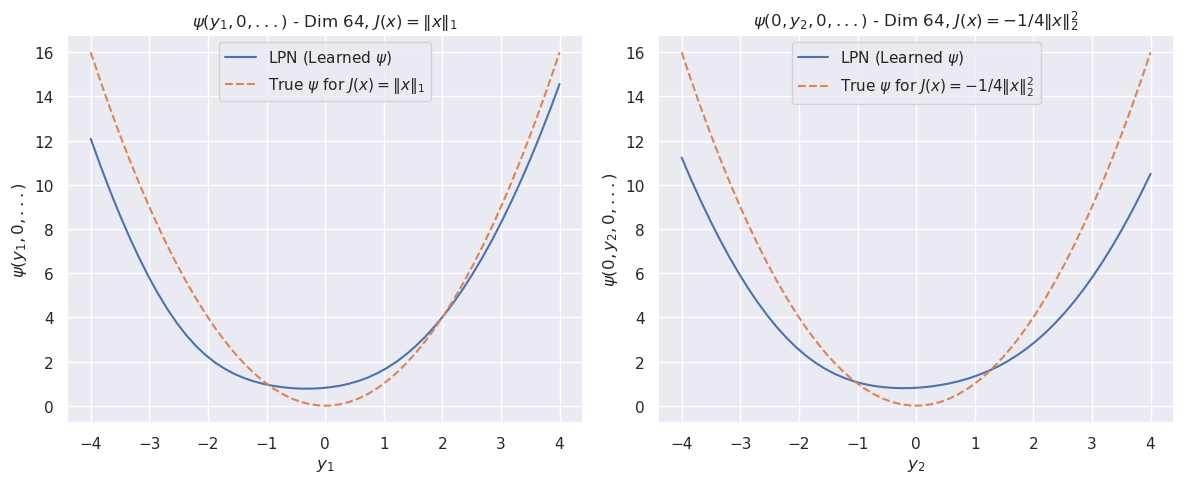

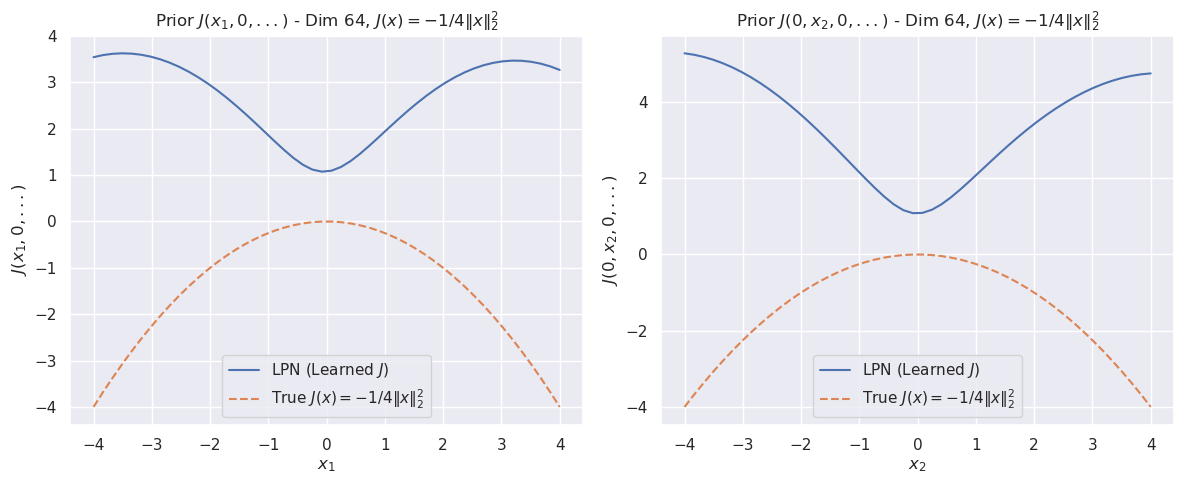

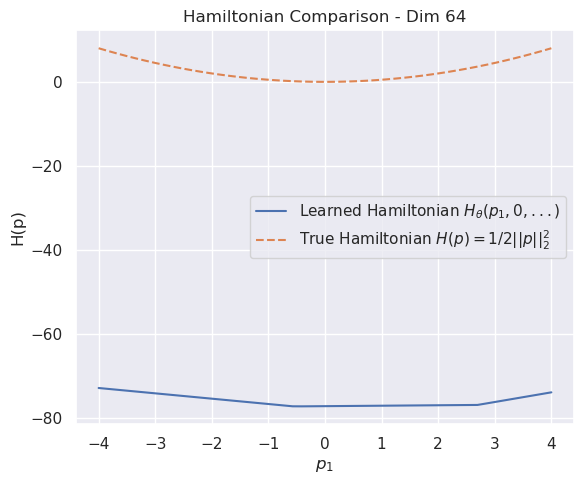

In [8]:
#print("\n--- Plotting Cross Sections for Quadratic H, Concave Quad Prior (Dim=4) ---")
plot_all_concave_quad(lpn_model_concave_quad_l2, a_exp, spacing, INVERT_MODE, dim_exp)

#print("\n--- Plotting Learned Hamiltonian for Quadratic H, Concave Quad Prior ---")
evaluate_learned_H(lpn_model_concave_quad_l2, a_exp, spacing, dim_exp)

In [9]:
# --- Generate New Training Data for the Second LPN G(x) ---
# We use the same x_j_exp_tensor as the first LPN's training data for x_k
x_k_tensor = y_j_exp_tensor.clone().to(device)
x_k_tensor.requires_grad_(True)

# 1. Compute the gradient y_k = grad_x psi_theta(x_k, t=1)
# Get psi(x_k)
psi_x_k = lpn_model_concave_quad_l2.scalar(x_k_tensor)

# Get gradient y_k = grad_psi(x_k)
y_k_tensor = lpn_model_concave_quad_l2(x_k_tensor)

# 2. Evaluate the "new" samples G_k = <y_k, x_k> - psi_theta(x_k, 1) (from eq 26)
inner_prod_yk_xk = torch.sum(y_k_tensor * x_k_tensor, dim=1, keepdim=True)
G_samples_tensor_with_graph = inner_prod_yk_xk - psi_x_k

# Detach the tensor to treat G_k as fixed targets, breaking the connection
# to the first LPN's graph and preventing the RuntimeError during training.
G_samples_tensor = G_samples_tensor_with_graph.detach().to(device) 

# The input tensor x_k_tensor is still needed for the second LPN training,
# but it should also not require a gradient for that training.
x_k_tensor = x_k_tensor.detach()
x_k_tensor.requires_grad_(False) 
y_k_tensor = y_k_tensor.detach()
y_k_tensor.requires_grad_(False)
# G_samples_tensor now holds the target values G_k
print(f"Generated G samples: G_samples_tensor shape {G_samples_tensor.shape}")


# def evaluate_updated_prior_J_hat(y_points, model, x_k_np):
#     """
#     Implements the approximate prior.
#     """
    
#     # Pre-compute y_k = grad psi(x_k) from the training data
#     x_k_tensor = torch.from_numpy(x_k_np).float().to(device)
#     y_k_tensor = model(x_k_tensor)
#     y_k_np = y_k_tensor.detach().cpu().numpy()
    
#     # Compute S(x_k, 1) = psi(x_k, t=1) from the LPN
#     S_x_k = model.scalar(x_k_tensor)  # Shape (K, 1)
#     S_x_k_np = S_x_k.detach().cpu().numpy().flatten()  # Shape (K,)
    
#     # The constant term simplifies to just S(x_k, 1)
#     # Because: J_tilde(y_k) + 1/2||x_k - y_k||^2 
#     #        = [S(x_k,1) - 1/2||x_k - y_k||^2] + 1/2||x_k - y_k||^2 
#     #        = S(x_k, 1)
#     constants_k = S_x_k_np  # Shape (K,)
    
#     # Term 3: -1/2 * ||x_k - y||^2
#     # Broadcasting: x_k_np (K, 1, dim), y_points (1, N, dim) -> (K, N)
#     term3 = -0.5 * np.sum((x_k_np[:, np.newaxis, :] - y_points[np.newaxis, :, :])**2, axis=2)
    
#     # Term 4: 1/4 * ||y - y_k||^2
#     # Broadcasting: y_points (1, N, dim), y_k_np (K, 1, dim) -> (K, N)
#     term4 = 0.25 * np.sum((y_points[np.newaxis, :, :] - y_k_np[:, np.newaxis, :])**2, axis=2)

#     term5 = 0.5 * np.sum((x_k_np[:, np.newaxis, :])**2, axis=2)
#     all_terms = term5 - constants_k[:, np.newaxis] + term3 
    
#     # # Combine all terms: constants_k (K, 1) + term3 (K, N) + term4 (K, N)
#     # all_terms = constants_k[:, np.newaxis] + term3 + term4
    
#     # Take the max over K dimension
#     j_hat_est = np.max(all_terms, axis=0)
    
#     return j_hat_est

# def plot_updated_prior_J_hat(model, a, spacing, dim, x_k_np):
#     """
#     Generates cross-section plots for the prior j_hat(y) from the "Update".
#     """
#     print(f"\n--- Plotting Updated Prior j_hat(y) (Dim={dim}) ---")
#     xi, y1_0_points, y2_0_points = compute_square_cross_sections(a, spacing, dim)

#     # Compute true prior J(y)
#     y1_0_J_true = prior_true_concave_quad(y1_0_points)
    
#     # Compute estimated prior j_hat(y)
#     y1_0_J_hat_est = evaluate_updated_prior_J_hat(y1_0_points, model, x_k_np)

#     plt.figure(figsize=(12, 5))
    
#     plt.subplot(1, 2, 1)
#     plt.plot(xi, y1_0_J_hat_est, "-", label="Approximate Prior $\\hat{J}(y)$")
#     plt.plot(xi, y1_0_J_true, "--", label="True Prior $J(y)=-1/4||y||_2^2$")
#     plt.grid(True)
#     plt.title(f"Updated Prior $\\hat{{J}}(y_1,0,...)$ - Dim {dim}")
#     plt.xlabel('$y_1$')
#     plt.ylabel('Prior Value')
#     plt.legend()

#     if dim > 1:
#         y2_0_J_true = prior_true_concave_quad(y2_0_points)
#         y2_0_J_hat_est = evaluate_updated_prior_J_hat(y2_0_points, model, x_k_np)
        
#         plt.subplot(1, 2, 2)
#         plt.plot(xi, y2_0_J_hat_est, "-", label="Approximate Prior $\\hat{J}(y)$")
#         plt.plot(xi, y2_0_J_true, "--", label="True Prior $J(y)=-1/4||y||_2^2$")
#         plt.grid(True)
#         plt.title(f"Updated Prior $\\hat{{J}}(0,y_2,0,...)$ - Dim {dim}")
#         plt.xlabel('$y_2$')
#         plt.ylabel('Prior Value')
#         plt.legend()
        
#     plt.tight_layout()
#     plt.show()


# # We use the original training data 'x_j_exp_np' as our set of x_k points.
# #subset_size = 1000 
# x_k_subset_np = y_j_exp_np#[:subset_size, :]

# plot_updated_prior_J_hat(lpn_model_concave_quad_l2, a_exp, spacing, dim_exp, x_k_subset_np)


Generated G samples: G_samples_tensor shape torch.Size([40000, 1])


In [10]:
# --- Step 3: Train LPN G(x) ---
print("\n--- Training Second LPN G(x) for Concave Quadratic Prior ---")
# The target for this LPN is G_samples_tensor
# The input for this LPN is x_k_tensor
lpn_model_G = LPN(in_dim=dim_exp, hidden=hidden, layers=layers, beta=beta, eps=1e-3).to(device)
optimizer_G = torch.optim.Adam(lpn_model_G.parameters(), lr=1e-4)

# Initial shorter training phase
for i in range(1):
     single_iteration(i, data_points_exp, lpn_model_G, optimizer_G, y_k_tensor, G_samples_tensor, loss_type=2, gamma_loss=None)

for g in optimizer_G.param_groups:
    g["lr"] = 1e-4 # Use a smaller learning rate for the long phase
for i in range(iterations_exp_long):
    if (i % 20000 == 0) and (i > 0): 
        # Multiply the current learning rate by 1e-1
        for g in optimizer_G.param_groups:
            new_lr = g["lr"] * 1e-1
            g["lr"] = new_lr
        print(f"Learning rate decreased to {new_lr} at iteration {i}")
    single_iteration(i, data_points_exp, lpn_model_G, optimizer_G, y_k_tensor, G_samples_tensor, loss_type=2, gamma_loss=None)

torch.save(lpn_model_G.state_dict(), os.path.join(MODEL_DIR, "G_network_l2.pth"))
print("Training of LPN for G(x) complete and model saved.")


--- Training Second LPN G(x) for Concave Quadratic Prior ---
iteration 0 loss 88705.5
iteration 0 loss 71059.03125


iteration 500 loss 837.8018798828125


iteration 1000 loss 581.2769165039062


iteration 1500 loss 406.7728271484375


iteration 2000 loss 296.2540283203125


iteration 2500 loss 229.7594757080078


iteration 3000 loss 191.2079620361328


iteration 3500 loss 169.02059936523438


iteration 4000 loss 155.3492889404297


iteration 4500 loss 145.58924865722656


iteration 5000 loss 137.42724609375


iteration 5500 loss 130.09230041503906


iteration 6000 loss 123.28767395019531


iteration 6500 loss 116.94688415527344


iteration 7000 loss 111.0938720703125


iteration 7500 loss 105.62786865234375


iteration 8000 loss 100.2984848022461


iteration 8500 loss 94.89424133300781


iteration 9000 loss 89.55243682861328


iteration 9500 loss 83.8580322265625


iteration 10000 loss 77.95966339111328


iteration 10500 loss 72.10004425048828


iteration 11000 loss 66.28428649902344


iteration 11500 loss 60.34681701660156


iteration 12000 loss 54.4323616027832


iteration 12500 loss 49.161582946777344


iteration 13000 loss 45.069095611572266


iteration 13500 loss 42.00746154785156


iteration 14000 loss 39.452125549316406


iteration 14500 loss 37.30448532104492


iteration 15000 loss 35.69306564331055


iteration 15500 loss 34.44524002075195


iteration 16000 loss 33.481746673583984


iteration 16500 loss 32.692501068115234


iteration 17000 loss 32.04977035522461


iteration 17500 loss 31.465389251708984


iteration 18000 loss 30.91522789001465


iteration 18500 loss 30.592660903930664


iteration 19000 loss 30.036418914794922


iteration 19500 loss 29.674827575683594


Learning rate decreased to 1e-05 at iteration 20000
iteration 20000 loss 29.36972427368164


iteration 20500 loss 29.339542388916016


iteration 21000 loss 29.3015079498291


iteration 21500 loss 29.253854751586914


iteration 22000 loss 29.195199966430664


iteration 22500 loss 29.123455047607422


iteration 23000 loss 29.036758422851562


iteration 23500 loss 28.934925079345703


iteration 24000 loss 28.81739616394043


iteration 24500 loss 28.684221267700195


iteration 25000 loss 28.5341796875


iteration 25500 loss 28.368343353271484


iteration 26000 loss 28.204206466674805


iteration 26500 loss 28.04647445678711


iteration 27000 loss 27.90192985534668


iteration 27500 loss 27.768329620361328


iteration 28000 loss 27.643083572387695


iteration 28500 loss 27.522464752197266


iteration 29000 loss 27.405609130859375


iteration 29500 loss 27.293684005737305


iteration 30000 loss 27.186004638671875


iteration 30500 loss 27.078536987304688


iteration 31000 loss 26.968231201171875


iteration 31500 loss 26.85666847229004


iteration 32000 loss 26.748605728149414


iteration 32500 loss 26.64569854736328


iteration 33000 loss 26.543825149536133


iteration 33500 loss 26.44536590576172


iteration 34000 loss 26.355754852294922


iteration 34500 loss 26.269498825073242


iteration 35000 loss 26.186708450317383


iteration 35500 loss 26.10394287109375


iteration 36000 loss 26.02150535583496


iteration 36500 loss 25.939128875732422


iteration 37000 loss 25.85858154296875


iteration 37500 loss 25.778911590576172


iteration 38000 loss 25.70534324645996


iteration 38500 loss 25.63410186767578


iteration 39000 loss 25.559974670410156


iteration 39500 loss 25.483333587646484


Learning rate decreased to 1.0000000000000002e-06 at iteration 40000
iteration 40000 loss 25.408592224121094


iteration 40500 loss 25.400630950927734


iteration 41000 loss 25.39164161682129


iteration 41500 loss 25.381526947021484


iteration 42000 loss 25.370298385620117


iteration 42500 loss 25.35801887512207


iteration 43000 loss 25.344812393188477


iteration 43500 loss 25.330833435058594


iteration 44000 loss 25.3162899017334


iteration 44500 loss 25.301305770874023


iteration 45000 loss 25.286014556884766


iteration 45500 loss 25.270492553710938


iteration 46000 loss 25.255077362060547


iteration 46500 loss 25.23975944519043


iteration 47000 loss 25.22459602355957


iteration 47500 loss 25.20954704284668


iteration 48000 loss 25.194580078125


iteration 48500 loss 25.179658889770508


iteration 49000 loss 25.164743423461914


iteration 49500 loss 25.149824142456055


iteration 50000 loss 25.134918212890625


iteration 50500 loss 25.120012283325195


iteration 51000 loss 25.105079650878906


iteration 51500 loss 25.089996337890625


iteration 52000 loss 25.07485580444336


iteration 52500 loss 25.05970573425293


iteration 53000 loss 25.044498443603516


iteration 53500 loss 25.029203414916992


iteration 54000 loss 25.013824462890625


iteration 54500 loss 24.998371124267578


iteration 55000 loss 24.982881546020508


iteration 55500 loss 24.9672908782959


iteration 56000 loss 24.95160675048828


iteration 56500 loss 24.935836791992188


iteration 57000 loss 24.919986724853516


iteration 57500 loss 24.90400505065918


iteration 58000 loss 24.887903213500977


iteration 58500 loss 24.871742248535156


iteration 59000 loss 24.855539321899414


iteration 59500 loss 24.839365005493164


Learning rate decreased to 1.0000000000000002e-07 at iteration 60000
iteration 60000 loss 24.823152542114258


iteration 60500 loss 24.821500778198242


iteration 61000 loss 24.819820404052734


iteration 61500 loss 24.818113327026367


iteration 62000 loss 24.816381454467773


iteration 62500 loss 24.814634323120117


iteration 63000 loss 24.812881469726562


iteration 63500 loss 24.811111450195312


iteration 64000 loss 24.80934715270996


iteration 64500 loss 24.807575225830078


iteration 65000 loss 24.805801391601562


iteration 65500 loss 24.804031372070312


iteration 66000 loss 24.80225944519043


iteration 66500 loss 24.80048370361328


iteration 67000 loss 24.798715591430664


iteration 67500 loss 24.796945571899414


iteration 68000 loss 24.79517364501953


iteration 68500 loss 24.793405532836914


iteration 69000 loss 24.791637420654297


iteration 69500 loss 24.789867401123047


iteration 70000 loss 24.788103103637695


iteration 70500 loss 24.786340713500977


iteration 71000 loss 24.78457260131836


iteration 71500 loss 24.782806396484375


iteration 72000 loss 24.781042098999023


iteration 72500 loss 24.779277801513672


iteration 73000 loss 24.777511596679688


iteration 73500 loss 24.77574920654297


iteration 74000 loss 24.773984909057617


iteration 74500 loss 24.772218704223633


iteration 75000 loss 24.77045440673828


iteration 75500 loss 24.76869010925293


iteration 76000 loss 24.766918182373047


iteration 76500 loss 24.765155792236328


iteration 77000 loss 24.763389587402344


iteration 77500 loss 24.761625289916992


iteration 78000 loss 24.75985336303711


iteration 78500 loss 24.758085250854492


iteration 79000 loss 24.756317138671875


iteration 79500 loss 24.754547119140625


Learning rate decreased to 1.0000000000000004e-08 at iteration 80000
iteration 80000 loss 24.752775192260742


iteration 80500 loss 24.752599716186523


iteration 81000 loss 24.752424240112305


iteration 81500 loss 24.752246856689453


iteration 82000 loss 24.75206756591797


iteration 82500 loss 24.751893997192383


iteration 83000 loss 24.751718521118164


iteration 83500 loss 24.75153923034668


iteration 84000 loss 24.751367568969727


iteration 84500 loss 24.75119400024414


iteration 85000 loss 24.75101661682129


iteration 85500 loss 24.750839233398438


iteration 86000 loss 24.75066566467285


iteration 86500 loss 24.750486373901367


iteration 87000 loss 24.75031280517578


iteration 87500 loss 24.75013542175293


iteration 88000 loss 24.749958038330078


iteration 88500 loss 24.749784469604492


iteration 89000 loss 24.749608993530273


iteration 89500 loss 24.749433517456055


iteration 90000 loss 24.749258041381836


iteration 90500 loss 24.74908447265625


iteration 91000 loss 24.74890899658203


iteration 91500 loss 24.74873161315918


iteration 92000 loss 24.74855613708496


iteration 92500 loss 24.748382568359375


iteration 93000 loss 24.748205184936523


iteration 93500 loss 24.748029708862305


iteration 94000 loss 24.74785614013672


iteration 94500 loss 24.7476806640625


iteration 95000 loss 24.74750518798828


iteration 95500 loss 24.747329711914062


iteration 96000 loss 24.747156143188477


iteration 96500 loss 24.74698257446289


iteration 97000 loss 24.74680519104004


iteration 97500 loss 24.746631622314453


iteration 98000 loss 24.7464542388916


iteration 98500 loss 24.746280670166016


iteration 99000 loss 24.746105194091797


iteration 99500 loss 24.745933532714844


Learning rate decreased to 1.0000000000000005e-09 at iteration 100000
iteration 100000 loss 24.745752334594727


iteration 100500 loss 24.74574851989746


iteration 101000 loss 24.745742797851562


iteration 101500 loss 24.745738983154297


iteration 102000 loss 24.7457332611084


iteration 102500 loss 24.7457275390625


iteration 103000 loss 24.74571990966797


iteration 103500 loss 24.745716094970703


iteration 104000 loss 24.745708465576172


iteration 104500 loss 24.745708465576172


iteration 105000 loss 24.74570083618164


iteration 105500 loss 24.745695114135742


iteration 106000 loss 24.745689392089844


iteration 106500 loss 24.745685577392578


iteration 107000 loss 24.745677947998047


iteration 107500 loss 24.745670318603516


iteration 108000 loss 24.745668411254883


iteration 108500 loss 24.745662689208984


iteration 109000 loss 24.74565887451172


iteration 109500 loss 24.74565315246582


iteration 110000 loss 24.74564552307129


iteration 110500 loss 24.745641708374023


iteration 111000 loss 24.745635986328125


iteration 111500 loss 24.74563217163086


iteration 112000 loss 24.745624542236328


iteration 112500 loss 24.74561882019043


iteration 113000 loss 24.74561309814453


iteration 113500 loss 24.745609283447266


iteration 114000 loss 24.745601654052734


iteration 114500 loss 24.7455997467041


iteration 115000 loss 24.745594024658203


iteration 115500 loss 24.745590209960938


iteration 116000 loss 24.74558448791504


iteration 116500 loss 24.745576858520508


iteration 117000 loss 24.745573043823242


iteration 117500 loss 24.745567321777344


iteration 118000 loss 24.745559692382812


iteration 118500 loss 24.745555877685547


iteration 119000 loss 24.74555206298828


iteration 119500 loss 24.74554443359375


Learning rate decreased to 1.0000000000000006e-10 at iteration 120000
iteration 120000 loss 24.745540618896484


iteration 120500 loss 24.745540618896484


iteration 121000 loss 24.745540618896484


iteration 121500 loss 24.745540618896484


iteration 122000 loss 24.745540618896484


iteration 122500 loss 24.745540618896484


iteration 123000 loss 24.745540618896484


iteration 123500 loss 24.745540618896484


iteration 124000 loss 24.745540618896484


iteration 124500 loss 24.745540618896484


iteration 125000 loss 24.745540618896484


iteration 125500 loss 24.745540618896484


iteration 126000 loss 24.745540618896484


iteration 126500 loss 24.745540618896484


iteration 127000 loss 24.745540618896484


iteration 127500 loss 24.745540618896484


iteration 128000 loss 24.745540618896484


iteration 128500 loss 24.74553871154785


iteration 129000 loss 24.74553871154785


iteration 129500 loss 24.745540618896484


iteration 130000 loss 24.745540618896484


iteration 130500 loss 24.745540618896484


iteration 131000 loss 24.745540618896484


iteration 131500 loss 24.74553871154785


iteration 132000 loss 24.745540618896484


iteration 132500 loss 24.745540618896484


iteration 133000 loss 24.745540618896484


iteration 133500 loss 24.745540618896484


iteration 134000 loss 24.74553871154785


iteration 134500 loss 24.745540618896484


iteration 135000 loss 24.74553680419922


iteration 135500 loss 24.74553680419922


iteration 136000 loss 24.74553680419922


iteration 136500 loss 24.74553680419922


iteration 137000 loss 24.74553680419922


iteration 137500 loss 24.745540618896484


iteration 138000 loss 24.74553680419922


iteration 138500 loss 24.745540618896484


iteration 139000 loss 24.74553871154785


iteration 139500 loss 24.74553680419922


Learning rate decreased to 1.0000000000000006e-11 at iteration 140000
iteration 140000 loss 24.74553871154785


iteration 140500 loss 24.74553871154785


iteration 141000 loss 24.74553871154785


iteration 141500 loss 24.74553871154785


iteration 142000 loss 24.74553871154785


iteration 142500 loss 24.74553871154785


iteration 143000 loss 24.74553871154785


iteration 143500 loss 24.74553871154785


iteration 144000 loss 24.74553871154785


iteration 144500 loss 24.74553871154785


iteration 145000 loss 24.745540618896484


iteration 145500 loss 24.74553871154785


iteration 146000 loss 24.74553871154785


iteration 146500 loss 24.74553871154785


iteration 147000 loss 24.745540618896484


iteration 147500 loss 24.745540618896484


iteration 148000 loss 24.74553871154785


iteration 148500 loss 24.74553871154785


iteration 149000 loss 24.74553871154785


iteration 149500 loss 24.74553871154785


iteration 150000 loss 24.74553871154785


iteration 150500 loss 24.74553871154785


iteration 151000 loss 24.74553871154785


iteration 151500 loss 24.74553871154785


iteration 152000 loss 24.74553871154785


iteration 152500 loss 24.74553871154785


iteration 153000 loss 24.74553680419922


iteration 153500 loss 24.74553871154785


iteration 154000 loss 24.74553871154785


iteration 154500 loss 24.74553871154785


iteration 155000 loss 24.74553680419922


iteration 155500 loss 24.74553680419922


iteration 156000 loss 24.74553871154785


iteration 156500 loss 24.74553680419922


iteration 157000 loss 24.745540618896484


iteration 157500 loss 24.745540618896484


iteration 158000 loss 24.74553871154785


iteration 158500 loss 24.74553871154785


iteration 159000 loss 24.74553871154785


iteration 159500 loss 24.745540618896484


Learning rate decreased to 1.0000000000000006e-12 at iteration 160000
iteration 160000 loss 24.745540618896484


iteration 160500 loss 24.745540618896484


iteration 161000 loss 24.745540618896484


iteration 161500 loss 24.745540618896484


iteration 162000 loss 24.745540618896484


iteration 162500 loss 24.745540618896484


iteration 163000 loss 24.745540618896484


iteration 163500 loss 24.745540618896484


iteration 164000 loss 24.745540618896484


iteration 164500 loss 24.745540618896484


iteration 165000 loss 24.745540618896484


iteration 165500 loss 24.745540618896484


iteration 166000 loss 24.745540618896484


iteration 166500 loss 24.745540618896484


iteration 167000 loss 24.745540618896484


iteration 167500 loss 24.745540618896484


iteration 168000 loss 24.745540618896484


iteration 168500 loss 24.745540618896484


iteration 169000 loss 24.745540618896484


iteration 169500 loss 24.745540618896484


iteration 170000 loss 24.745540618896484


iteration 170500 loss 24.745540618896484


iteration 171000 loss 24.745540618896484


iteration 171500 loss 24.745540618896484


iteration 172000 loss 24.745540618896484


iteration 172500 loss 24.745540618896484


iteration 173000 loss 24.745540618896484


iteration 173500 loss 24.745540618896484


iteration 174000 loss 24.745540618896484


iteration 174500 loss 24.745540618896484


iteration 175000 loss 24.745540618896484


iteration 175500 loss 24.745540618896484


iteration 176000 loss 24.745540618896484


iteration 176500 loss 24.745540618896484


iteration 177000 loss 24.745540618896484


iteration 177500 loss 24.745540618896484


iteration 178000 loss 24.745540618896484


iteration 178500 loss 24.745540618896484


iteration 179000 loss 24.745540618896484


iteration 179500 loss 24.745540618896484


Learning rate decreased to 1.0000000000000007e-13 at iteration 180000
iteration 180000 loss 24.745540618896484


iteration 180500 loss 24.745540618896484


iteration 181000 loss 24.745540618896484


iteration 181500 loss 24.745540618896484


iteration 182000 loss 24.745540618896484


iteration 182500 loss 24.745540618896484


iteration 183000 loss 24.745540618896484


iteration 183500 loss 24.745540618896484


iteration 184000 loss 24.745540618896484


iteration 184500 loss 24.745540618896484


iteration 185000 loss 24.745540618896484


iteration 185500 loss 24.745540618896484


iteration 186000 loss 24.745540618896484


iteration 186500 loss 24.745540618896484


iteration 187000 loss 24.745540618896484


iteration 187500 loss 24.745540618896484


iteration 188000 loss 24.745540618896484


iteration 188500 loss 24.745540618896484


iteration 189000 loss 24.745540618896484


iteration 189500 loss 24.745540618896484


iteration 190000 loss 24.745540618896484


iteration 190500 loss 24.745540618896484


iteration 191000 loss 24.745540618896484


iteration 191500 loss 24.745540618896484


iteration 192000 loss 24.745540618896484


iteration 192500 loss 24.745540618896484


iteration 193000 loss 24.745540618896484


iteration 193500 loss 24.745540618896484


iteration 194000 loss 24.745540618896484


iteration 194500 loss 24.745540618896484


iteration 195000 loss 24.745540618896484


iteration 195500 loss 24.745540618896484


iteration 196000 loss 24.745540618896484


iteration 196500 loss 24.745540618896484


iteration 197000 loss 24.745540618896484


iteration 197500 loss 24.745540618896484


iteration 198000 loss 24.745540618896484


iteration 198500 loss 24.745540618896484


iteration 199000 loss 24.745540618896484


iteration 199500 loss 24.745540618896484


Learning rate decreased to 1.0000000000000008e-14 at iteration 200000
iteration 200000 loss 24.745540618896484


iteration 200500 loss 24.745540618896484


iteration 201000 loss 24.745540618896484


iteration 201500 loss 24.745540618896484


iteration 202000 loss 24.745540618896484


iteration 202500 loss 24.745540618896484


iteration 203000 loss 24.745540618896484


iteration 203500 loss 24.745540618896484


iteration 204000 loss 24.745540618896484


iteration 204500 loss 24.745540618896484


iteration 205000 loss 24.745540618896484


iteration 205500 loss 24.745540618896484


iteration 206000 loss 24.745540618896484


iteration 206500 loss 24.745540618896484


iteration 207000 loss 24.745540618896484


iteration 207500 loss 24.745540618896484


iteration 208000 loss 24.745540618896484


iteration 208500 loss 24.745540618896484


iteration 209000 loss 24.745540618896484


iteration 209500 loss 24.745540618896484


iteration 210000 loss 24.745540618896484


iteration 210500 loss 24.745540618896484


iteration 211000 loss 24.745540618896484


iteration 211500 loss 24.745540618896484


iteration 212000 loss 24.745540618896484


iteration 212500 loss 24.745540618896484


iteration 213000 loss 24.745540618896484


iteration 213500 loss 24.745540618896484


iteration 214000 loss 24.745540618896484


iteration 214500 loss 24.745540618896484


iteration 215000 loss 24.745540618896484


iteration 215500 loss 24.745540618896484


iteration 216000 loss 24.745540618896484


iteration 216500 loss 24.745540618896484


iteration 217000 loss 24.745540618896484


iteration 217500 loss 24.745540618896484


iteration 218000 loss 24.745540618896484


iteration 218500 loss 24.745540618896484


iteration 219000 loss 24.745540618896484


iteration 219500 loss 24.745540618896484


Learning rate decreased to 1.0000000000000009e-15 at iteration 220000
iteration 220000 loss 24.745540618896484


iteration 220500 loss 24.745540618896484


iteration 221000 loss 24.745540618896484


iteration 221500 loss 24.745540618896484


iteration 222000 loss 24.745540618896484


iteration 222500 loss 24.745540618896484


iteration 223000 loss 24.745540618896484


iteration 223500 loss 24.745540618896484


iteration 224000 loss 24.745540618896484


iteration 224500 loss 24.745540618896484


iteration 225000 loss 24.745540618896484


iteration 225500 loss 24.745540618896484


iteration 226000 loss 24.745540618896484


iteration 226500 loss 24.745540618896484


iteration 227000 loss 24.745540618896484


iteration 227500 loss 24.745540618896484


iteration 228000 loss 24.745540618896484


iteration 228500 loss 24.745540618896484


iteration 229000 loss 24.745540618896484


iteration 229500 loss 24.745540618896484


iteration 230000 loss 24.745540618896484


iteration 230500 loss 24.745540618896484


iteration 231000 loss 24.745540618896484


iteration 231500 loss 24.745540618896484


iteration 232000 loss 24.745540618896484


iteration 232500 loss 24.745540618896484


iteration 233000 loss 24.745540618896484


iteration 233500 loss 24.745540618896484


iteration 234000 loss 24.745540618896484


iteration 234500 loss 24.745540618896484


iteration 235000 loss 24.745540618896484


iteration 235500 loss 24.745540618896484


iteration 236000 loss 24.745540618896484


iteration 236500 loss 24.745540618896484


iteration 237000 loss 24.745540618896484


iteration 237500 loss 24.745540618896484


iteration 238000 loss 24.745540618896484


iteration 238500 loss 24.745540618896484


iteration 239000 loss 24.745540618896484


iteration 239500 loss 24.745540618896484


Learning rate decreased to 1.000000000000001e-16 at iteration 240000
iteration 240000 loss 24.745540618896484


iteration 240500 loss 24.745540618896484


iteration 241000 loss 24.745540618896484


iteration 241500 loss 24.745540618896484


iteration 242000 loss 24.745540618896484


iteration 242500 loss 24.745540618896484


iteration 243000 loss 24.745540618896484


iteration 243500 loss 24.745540618896484


iteration 244000 loss 24.745540618896484


iteration 244500 loss 24.745540618896484


iteration 245000 loss 24.745540618896484


iteration 245500 loss 24.745540618896484


iteration 246000 loss 24.745540618896484


iteration 246500 loss 24.745540618896484


iteration 247000 loss 24.745540618896484


iteration 247500 loss 24.745540618896484


iteration 248000 loss 24.745540618896484


iteration 248500 loss 24.745540618896484


iteration 249000 loss 24.745540618896484


iteration 249500 loss 24.745540618896484


iteration 250000 loss 24.745540618896484


iteration 250500 loss 24.745540618896484


iteration 251000 loss 24.745540618896484


iteration 251500 loss 24.745540618896484


iteration 252000 loss 24.745540618896484


iteration 252500 loss 24.745540618896484


iteration 253000 loss 24.745540618896484


iteration 253500 loss 24.745540618896484


iteration 254000 loss 24.745540618896484


iteration 254500 loss 24.745540618896484


iteration 255000 loss 24.745540618896484


iteration 255500 loss 24.745540618896484


iteration 256000 loss 24.745540618896484


iteration 256500 loss 24.745540618896484


iteration 257000 loss 24.745540618896484


iteration 257500 loss 24.745540618896484


iteration 258000 loss 24.745540618896484


iteration 258500 loss 24.745540618896484


iteration 259000 loss 24.745540618896484


iteration 259500 loss 24.745540618896484


Learning rate decreased to 1.000000000000001e-17 at iteration 260000
iteration 260000 loss 24.745540618896484


iteration 260500 loss 24.745540618896484


iteration 261000 loss 24.745540618896484


iteration 261500 loss 24.745540618896484


iteration 262000 loss 24.745540618896484


iteration 262500 loss 24.745540618896484


iteration 263000 loss 24.745540618896484


iteration 263500 loss 24.745540618896484


iteration 264000 loss 24.745540618896484


iteration 264500 loss 24.745540618896484


iteration 265000 loss 24.745540618896484


iteration 265500 loss 24.745540618896484


iteration 266000 loss 24.745540618896484


iteration 266500 loss 24.745540618896484


iteration 267000 loss 24.745540618896484


iteration 267500 loss 24.745540618896484


iteration 268000 loss 24.745540618896484


iteration 268500 loss 24.745540618896484


iteration 269000 loss 24.745540618896484


iteration 269500 loss 24.745540618896484


iteration 270000 loss 24.745540618896484


iteration 270500 loss 24.745540618896484


iteration 271000 loss 24.745540618896484


iteration 271500 loss 24.745540618896484


iteration 272000 loss 24.745540618896484


iteration 272500 loss 24.745540618896484


iteration 273000 loss 24.745540618896484


iteration 273500 loss 24.745540618896484


iteration 274000 loss 24.745540618896484


iteration 274500 loss 24.745540618896484


iteration 275000 loss 24.745540618896484


iteration 275500 loss 24.745540618896484


iteration 276000 loss 24.745540618896484


iteration 276500 loss 24.745540618896484


iteration 277000 loss 24.745540618896484


iteration 277500 loss 24.745540618896484


iteration 278000 loss 24.745540618896484


iteration 278500 loss 24.745540618896484


iteration 279000 loss 24.745540618896484


iteration 279500 loss 24.745540618896484


Learning rate decreased to 1.000000000000001e-18 at iteration 280000
iteration 280000 loss 24.745540618896484


iteration 280500 loss 24.745540618896484


iteration 281000 loss 24.745540618896484


iteration 281500 loss 24.745540618896484


iteration 282000 loss 24.745540618896484


iteration 282500 loss 24.745540618896484


iteration 283000 loss 24.745540618896484


iteration 283500 loss 24.745540618896484


iteration 284000 loss 24.745540618896484


iteration 284500 loss 24.745540618896484


iteration 285000 loss 24.745540618896484


iteration 285500 loss 24.745540618896484


iteration 286000 loss 24.745540618896484


iteration 286500 loss 24.745540618896484


iteration 287000 loss 24.745540618896484


iteration 287500 loss 24.745540618896484


iteration 288000 loss 24.745540618896484


iteration 288500 loss 24.745540618896484


iteration 289000 loss 24.745540618896484


iteration 289500 loss 24.745540618896484


iteration 290000 loss 24.745540618896484


iteration 290500 loss 24.745540618896484


iteration 291000 loss 24.745540618896484


iteration 291500 loss 24.745540618896484


iteration 292000 loss 24.745540618896484


iteration 292500 loss 24.745540618896484


iteration 293000 loss 24.745540618896484


iteration 293500 loss 24.745540618896484


iteration 294000 loss 24.745540618896484


iteration 294500 loss 24.745540618896484


iteration 295000 loss 24.745540618896484


iteration 295500 loss 24.745540618896484


iteration 296000 loss 24.745540618896484


iteration 296500 loss 24.745540618896484


iteration 297000 loss 24.745540618896484


iteration 297500 loss 24.745540618896484


iteration 298000 loss 24.745540618896484


iteration 298500 loss 24.745540618896484


iteration 299000 loss 24.745540618896484


iteration 299500 loss 24.745540618896484


Learning rate decreased to 1.000000000000001e-19 at iteration 300000
iteration 300000 loss 24.745540618896484


iteration 300500 loss 24.745540618896484


iteration 301000 loss 24.745540618896484


iteration 301500 loss 24.745540618896484


iteration 302000 loss 24.745540618896484


iteration 302500 loss 24.745540618896484


iteration 303000 loss 24.745540618896484


iteration 303500 loss 24.745540618896484


iteration 304000 loss 24.745540618896484


iteration 304500 loss 24.745540618896484


iteration 305000 loss 24.745540618896484


iteration 305500 loss 24.745540618896484


iteration 306000 loss 24.745540618896484


iteration 306500 loss 24.745540618896484


iteration 307000 loss 24.745540618896484


iteration 307500 loss 24.745540618896484


iteration 308000 loss 24.745540618896484


iteration 308500 loss 24.745540618896484


iteration 309000 loss 24.745540618896484


iteration 309500 loss 24.745540618896484


iteration 310000 loss 24.745540618896484


iteration 310500 loss 24.745540618896484


iteration 311000 loss 24.745540618896484


iteration 311500 loss 24.745540618896484


iteration 312000 loss 24.745540618896484


iteration 312500 loss 24.745540618896484


iteration 313000 loss 24.745540618896484


iteration 313500 loss 24.745540618896484


iteration 314000 loss 24.745540618896484


iteration 314500 loss 24.745540618896484


iteration 315000 loss 24.745540618896484


iteration 315500 loss 24.745540618896484


iteration 316000 loss 24.745540618896484


iteration 316500 loss 24.745540618896484


iteration 317000 loss 24.745540618896484


iteration 317500 loss 24.745540618896484


iteration 318000 loss 24.745540618896484


iteration 318500 loss 24.745540618896484


iteration 319000 loss 24.745540618896484


iteration 319500 loss 24.745540618896484


Learning rate decreased to 1.0000000000000011e-20 at iteration 320000
iteration 320000 loss 24.745540618896484


iteration 320500 loss 24.745540618896484


iteration 321000 loss 24.745540618896484


iteration 321500 loss 24.745540618896484


iteration 322000 loss 24.745540618896484


iteration 322500 loss 24.745540618896484


iteration 323000 loss 24.745540618896484


iteration 323500 loss 24.745540618896484


iteration 324000 loss 24.745540618896484


iteration 324500 loss 24.745540618896484


iteration 325000 loss 24.745540618896484


iteration 325500 loss 24.745540618896484


iteration 326000 loss 24.745540618896484


iteration 326500 loss 24.745540618896484


iteration 327000 loss 24.745540618896484


iteration 327500 loss 24.745540618896484


iteration 328000 loss 24.745540618896484


iteration 328500 loss 24.745540618896484


iteration 329000 loss 24.745540618896484


iteration 329500 loss 24.745540618896484


iteration 330000 loss 24.745540618896484


iteration 330500 loss 24.745540618896484


iteration 331000 loss 24.745540618896484


iteration 331500 loss 24.745540618896484


iteration 332000 loss 24.745540618896484


iteration 332500 loss 24.745540618896484


iteration 333000 loss 24.745540618896484


iteration 333500 loss 24.745540618896484


iteration 334000 loss 24.745540618896484


iteration 334500 loss 24.745540618896484


iteration 335000 loss 24.745540618896484


iteration 335500 loss 24.745540618896484


iteration 336000 loss 24.745540618896484


iteration 336500 loss 24.745540618896484


iteration 337000 loss 24.745540618896484


iteration 337500 loss 24.745540618896484


iteration 338000 loss 24.745540618896484


iteration 338500 loss 24.745540618896484


iteration 339000 loss 24.745540618896484


iteration 339500 loss 24.745540618896484


Learning rate decreased to 1.0000000000000012e-21 at iteration 340000
iteration 340000 loss 24.745540618896484


iteration 340500 loss 24.745540618896484


iteration 341000 loss 24.745540618896484


iteration 341500 loss 24.745540618896484


iteration 342000 loss 24.745540618896484


iteration 342500 loss 24.745540618896484


iteration 343000 loss 24.745540618896484


iteration 343500 loss 24.745540618896484


iteration 344000 loss 24.745540618896484


iteration 344500 loss 24.745540618896484


iteration 345000 loss 24.745540618896484


iteration 345500 loss 24.745540618896484


iteration 346000 loss 24.745540618896484


iteration 346500 loss 24.745540618896484


iteration 347000 loss 24.745540618896484


iteration 347500 loss 24.745540618896484


iteration 348000 loss 24.745540618896484


iteration 348500 loss 24.745540618896484


iteration 349000 loss 24.745540618896484


iteration 349500 loss 24.745540618896484


iteration 350000 loss 24.745540618896484


iteration 350500 loss 24.745540618896484


iteration 351000 loss 24.745540618896484


iteration 351500 loss 24.745540618896484


iteration 352000 loss 24.745540618896484


iteration 352500 loss 24.745540618896484


iteration 353000 loss 24.745540618896484


iteration 353500 loss 24.745540618896484


iteration 354000 loss 24.745540618896484


iteration 354500 loss 24.745540618896484


iteration 355000 loss 24.745540618896484


iteration 355500 loss 24.745540618896484


iteration 356000 loss 24.745540618896484


iteration 356500 loss 24.745540618896484


iteration 357000 loss 24.745540618896484


iteration 357500 loss 24.745540618896484


iteration 358000 loss 24.745540618896484


iteration 358500 loss 24.745540618896484


iteration 359000 loss 24.745540618896484


iteration 359500 loss 24.745540618896484


Learning rate decreased to 1.0000000000000012e-22 at iteration 360000
iteration 360000 loss 24.745540618896484


iteration 360500 loss 24.745540618896484


iteration 361000 loss 24.745540618896484


iteration 361500 loss 24.745540618896484


iteration 362000 loss 24.745540618896484


iteration 362500 loss 24.745540618896484


iteration 363000 loss 24.745540618896484


iteration 363500 loss 24.745540618896484


iteration 364000 loss 24.745540618896484


iteration 364500 loss 24.745540618896484


iteration 365000 loss 24.745540618896484


iteration 365500 loss 24.745540618896484


iteration 366000 loss 24.745540618896484


iteration 366500 loss 24.745540618896484


iteration 367000 loss 24.745540618896484


iteration 367500 loss 24.745540618896484


iteration 368000 loss 24.745540618896484


iteration 368500 loss 24.745540618896484


iteration 369000 loss 24.745540618896484


iteration 369500 loss 24.745540618896484


iteration 370000 loss 24.745540618896484


iteration 370500 loss 24.745540618896484


iteration 371000 loss 24.745540618896484


iteration 371500 loss 24.745540618896484


iteration 372000 loss 24.745540618896484


iteration 372500 loss 24.745540618896484


iteration 373000 loss 24.745540618896484


iteration 373500 loss 24.745540618896484


iteration 374000 loss 24.745540618896484


iteration 374500 loss 24.745540618896484


iteration 375000 loss 24.745540618896484


iteration 375500 loss 24.745540618896484


iteration 376000 loss 24.745540618896484


iteration 376500 loss 24.745540618896484


iteration 377000 loss 24.745540618896484


iteration 377500 loss 24.745540618896484


iteration 378000 loss 24.745540618896484


iteration 378500 loss 24.745540618896484


iteration 379000 loss 24.745540618896484


iteration 379500 loss 24.745540618896484


Learning rate decreased to 1.0000000000000013e-23 at iteration 380000
iteration 380000 loss 24.745540618896484


iteration 380500 loss 24.745540618896484


iteration 381000 loss 24.745540618896484


iteration 381500 loss 24.745540618896484


iteration 382000 loss 24.745540618896484


iteration 382500 loss 24.745540618896484


iteration 383000 loss 24.745540618896484


iteration 383500 loss 24.745540618896484


iteration 384000 loss 24.745540618896484


iteration 384500 loss 24.745540618896484


iteration 385000 loss 24.745540618896484


iteration 385500 loss 24.745540618896484


iteration 386000 loss 24.745540618896484


iteration 386500 loss 24.745540618896484


iteration 387000 loss 24.745540618896484


iteration 387500 loss 24.745540618896484


iteration 388000 loss 24.745540618896484


iteration 388500 loss 24.745540618896484


iteration 389000 loss 24.745540618896484


iteration 389500 loss 24.745540618896484


iteration 390000 loss 24.745540618896484


iteration 390500 loss 24.745540618896484


iteration 391000 loss 24.745540618896484


iteration 391500 loss 24.745540618896484


iteration 392000 loss 24.745540618896484


iteration 392500 loss 24.745540618896484


iteration 393000 loss 24.745540618896484


iteration 393500 loss 24.745540618896484


iteration 394000 loss 24.745540618896484


iteration 394500 loss 24.745540618896484


iteration 395000 loss 24.745540618896484


iteration 395500 loss 24.745540618896484


iteration 396000 loss 24.745540618896484


iteration 396500 loss 24.745540618896484


iteration 397000 loss 24.745540618896484


iteration 397500 loss 24.745540618896484


iteration 398000 loss 24.745540618896484


iteration 398500 loss 24.745540618896484


iteration 399000 loss 24.745540618896484


iteration 399500 loss 24.745540618896484


Learning rate decreased to 1.0000000000000014e-24 at iteration 400000
iteration 400000 loss 24.745540618896484


iteration 400500 loss 24.745540618896484


iteration 401000 loss 24.745540618896484


iteration 401500 loss 24.745540618896484


iteration 402000 loss 24.745540618896484


iteration 402500 loss 24.745540618896484


iteration 403000 loss 24.745540618896484


iteration 403500 loss 24.745540618896484


iteration 404000 loss 24.745540618896484


iteration 404500 loss 24.745540618896484


iteration 405000 loss 24.745540618896484


iteration 405500 loss 24.745540618896484


iteration 406000 loss 24.745540618896484


iteration 406500 loss 24.745540618896484


iteration 407000 loss 24.745540618896484


iteration 407500 loss 24.745540618896484


iteration 408000 loss 24.745540618896484


iteration 408500 loss 24.745540618896484


iteration 409000 loss 24.745540618896484


iteration 409500 loss 24.745540618896484


iteration 410000 loss 24.745540618896484


iteration 410500 loss 24.745540618896484


iteration 411000 loss 24.745540618896484


iteration 411500 loss 24.745540618896484


iteration 412000 loss 24.745540618896484


iteration 412500 loss 24.745540618896484


iteration 413000 loss 24.745540618896484


iteration 413500 loss 24.745540618896484


iteration 414000 loss 24.745540618896484


iteration 414500 loss 24.745540618896484


iteration 415000 loss 24.745540618896484


iteration 415500 loss 24.745540618896484


iteration 416000 loss 24.745540618896484


iteration 416500 loss 24.745540618896484


iteration 417000 loss 24.745540618896484


iteration 417500 loss 24.745540618896484


iteration 418000 loss 24.745540618896484


iteration 418500 loss 24.745540618896484


iteration 419000 loss 24.745540618896484


iteration 419500 loss 24.745540618896484


Learning rate decreased to 1.0000000000000014e-25 at iteration 420000
iteration 420000 loss 24.745540618896484


iteration 420500 loss 24.745540618896484


iteration 421000 loss 24.745540618896484


iteration 421500 loss 24.745540618896484


iteration 422000 loss 24.745540618896484


iteration 422500 loss 24.745540618896484


iteration 423000 loss 24.745540618896484


iteration 423500 loss 24.745540618896484


iteration 424000 loss 24.745540618896484


iteration 424500 loss 24.745540618896484


iteration 425000 loss 24.745540618896484


iteration 425500 loss 24.745540618896484


iteration 426000 loss 24.745540618896484


iteration 426500 loss 24.745540618896484


iteration 427000 loss 24.745540618896484


iteration 427500 loss 24.745540618896484


iteration 428000 loss 24.745540618896484


iteration 428500 loss 24.745540618896484


iteration 429000 loss 24.745540618896484


iteration 429500 loss 24.745540618896484


iteration 430000 loss 24.745540618896484


iteration 430500 loss 24.745540618896484


iteration 431000 loss 24.745540618896484


iteration 431500 loss 24.745540618896484


iteration 432000 loss 24.745540618896484


iteration 432500 loss 24.745540618896484


iteration 433000 loss 24.745540618896484


iteration 433500 loss 24.745540618896484


iteration 434000 loss 24.745540618896484


iteration 434500 loss 24.745540618896484


iteration 435000 loss 24.745540618896484


iteration 435500 loss 24.745540618896484


iteration 436000 loss 24.745540618896484


iteration 436500 loss 24.745540618896484


iteration 437000 loss 24.745540618896484


iteration 437500 loss 24.745540618896484


iteration 438000 loss 24.745540618896484


iteration 438500 loss 24.745540618896484


iteration 439000 loss 24.745540618896484


iteration 439500 loss 24.745540618896484


Learning rate decreased to 1.0000000000000015e-26 at iteration 440000
iteration 440000 loss 24.745540618896484


iteration 440500 loss 24.745540618896484


iteration 441000 loss 24.745540618896484


iteration 441500 loss 24.745540618896484


iteration 442000 loss 24.745540618896484


iteration 442500 loss 24.745540618896484


iteration 443000 loss 24.745540618896484


iteration 443500 loss 24.745540618896484


iteration 444000 loss 24.745540618896484


iteration 444500 loss 24.745540618896484


iteration 445000 loss 24.745540618896484


iteration 445500 loss 24.745540618896484


iteration 446000 loss 24.745540618896484


iteration 446500 loss 24.745540618896484


iteration 447000 loss 24.745540618896484


iteration 447500 loss 24.745540618896484


iteration 448000 loss 24.745540618896484


iteration 448500 loss 24.745540618896484


iteration 449000 loss 24.745540618896484


iteration 449500 loss 24.745540618896484


iteration 450000 loss 24.745540618896484


iteration 450500 loss 24.745540618896484


iteration 451000 loss 24.745540618896484


iteration 451500 loss 24.745540618896484


iteration 452000 loss 24.745540618896484


iteration 452500 loss 24.745540618896484


iteration 453000 loss 24.745540618896484


iteration 453500 loss 24.745540618896484


iteration 454000 loss 24.745540618896484


iteration 454500 loss 24.745540618896484


iteration 455000 loss 24.745540618896484


iteration 455500 loss 24.745540618896484


iteration 456000 loss 24.745540618896484


iteration 456500 loss 24.745540618896484


iteration 457000 loss 24.745540618896484


iteration 457500 loss 24.745540618896484


iteration 458000 loss 24.745540618896484


iteration 458500 loss 24.745540618896484


iteration 459000 loss 24.745540618896484


iteration 459500 loss 24.745540618896484


Learning rate decreased to 1.0000000000000015e-27 at iteration 460000
iteration 460000 loss 24.745540618896484


iteration 460500 loss 24.745540618896484


iteration 461000 loss 24.745540618896484


iteration 461500 loss 24.745540618896484


iteration 462000 loss 24.745540618896484


iteration 462500 loss 24.745540618896484


iteration 463000 loss 24.745540618896484


iteration 463500 loss 24.745540618896484


iteration 464000 loss 24.745540618896484


iteration 464500 loss 24.745540618896484


iteration 465000 loss 24.745540618896484


iteration 465500 loss 24.745540618896484


iteration 466000 loss 24.745540618896484


iteration 466500 loss 24.745540618896484


iteration 467000 loss 24.745540618896484


iteration 467500 loss 24.745540618896484


iteration 468000 loss 24.745540618896484


iteration 468500 loss 24.745540618896484


iteration 469000 loss 24.745540618896484


iteration 469500 loss 24.745540618896484


iteration 470000 loss 24.745540618896484


iteration 470500 loss 24.745540618896484


iteration 471000 loss 24.745540618896484


iteration 471500 loss 24.745540618896484


iteration 472000 loss 24.745540618896484


iteration 472500 loss 24.745540618896484


iteration 473000 loss 24.745540618896484


iteration 473500 loss 24.745540618896484


iteration 474000 loss 24.745540618896484


iteration 474500 loss 24.745540618896484


iteration 475000 loss 24.745540618896484


iteration 475500 loss 24.745540618896484


iteration 476000 loss 24.745540618896484


iteration 476500 loss 24.745540618896484


iteration 477000 loss 24.745540618896484


iteration 477500 loss 24.745540618896484


iteration 478000 loss 24.745540618896484


iteration 478500 loss 24.745540618896484


iteration 479000 loss 24.745540618896484


iteration 479500 loss 24.745540618896484


Learning rate decreased to 1.0000000000000015e-28 at iteration 480000
iteration 480000 loss 24.745540618896484


iteration 480500 loss 24.745540618896484


iteration 481000 loss 24.745540618896484


iteration 481500 loss 24.745540618896484


iteration 482000 loss 24.745540618896484


iteration 482500 loss 24.745540618896484


iteration 483000 loss 24.745540618896484


iteration 483500 loss 24.745540618896484


iteration 484000 loss 24.745540618896484


iteration 484500 loss 24.745540618896484


iteration 485000 loss 24.745540618896484


iteration 485500 loss 24.745540618896484


iteration 486000 loss 24.745540618896484


iteration 486500 loss 24.745540618896484


iteration 487000 loss 24.745540618896484


iteration 487500 loss 24.745540618896484


iteration 488000 loss 24.745540618896484


iteration 488500 loss 24.745540618896484


iteration 489000 loss 24.745540618896484


iteration 489500 loss 24.745540618896484


iteration 490000 loss 24.745540618896484


iteration 490500 loss 24.745540618896484


iteration 491000 loss 24.745540618896484


iteration 491500 loss 24.745540618896484


iteration 492000 loss 24.745540618896484


iteration 492500 loss 24.745540618896484


iteration 493000 loss 24.745540618896484


iteration 493500 loss 24.745540618896484


iteration 494000 loss 24.745540618896484


iteration 494500 loss 24.745540618896484


iteration 495000 loss 24.745540618896484


iteration 495500 loss 24.745540618896484


iteration 496000 loss 24.745540618896484


iteration 496500 loss 24.745540618896484


iteration 497000 loss 24.745540618896484


iteration 497500 loss 24.745540618896484


iteration 498000 loss 24.745540618896484


iteration 498500 loss 24.745540618896484


iteration 499000 loss 24.745540618896484


iteration 499500 loss 24.745540618896484


Training of LPN for G(x) complete and model saved.



--- Plotting Estimated Prior J(x) from LPN 2 ---


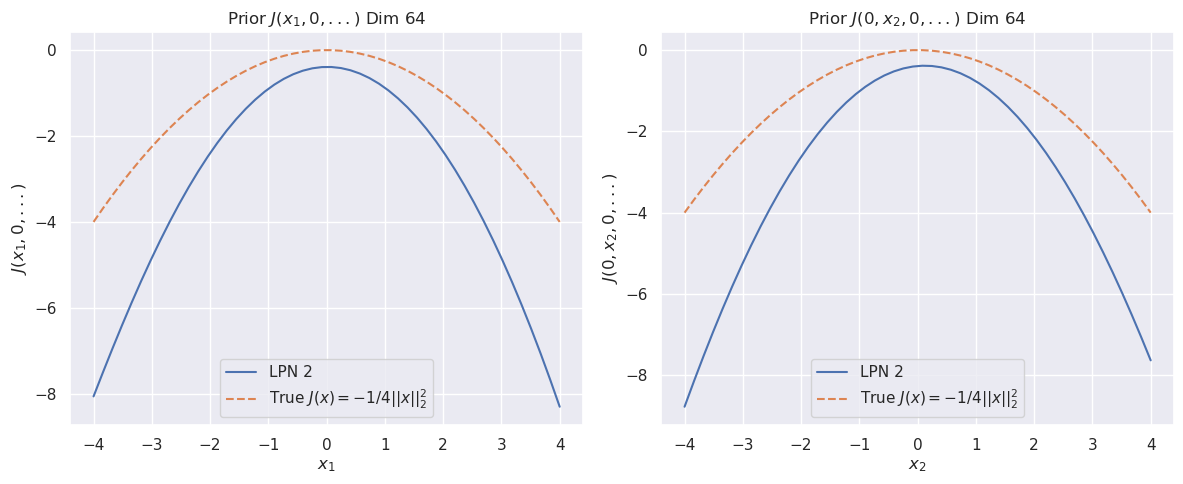

In [11]:
def evaluate_learned_J_G_network(x_points, model_G):
    """
    Evaluates the learned prior J(x) using the trained G(x) network.
    J(x) = G(x) - 0.5 * ||x||^2
    """
    # Convert to tensor
    x_tensor = torch.from_numpy(x_points).float().to(device)
    
    # Get G(x) from the second LPN model
    G_x = model_G.scalar(x_tensor)
    
    # Compute 0.5 * ||x||^2
    x_norm_sq_np = euclid_norm_sq(x_points)
    x_norm_sq_tensor = torch.from_numpy(x_norm_sq_np).float().to(device).reshape(-1, 1)

    # Apply the formula: J_est = G(x) - 0.5 * ||x||^2
    J_est = G_x - 0.5 * x_norm_sq_tensor
    
    # Convert back to numpy
    J_est_np = J_est.detach().cpu().numpy().flatten()
    
    return J_est_np

def plot_J_G_network(model_G, a, spacing, dim):
    """Plots the cross-sections of the estimated prior J(x) from the G network."""
    xi, x1_0_points, x2_0_points = compute_square_cross_sections(a, spacing, dim)
    
    # True Prior
    x1_0_J_true = prior_true_concave_quad(x1_0_points)
    if dim > 1:
        x2_0_J_true = prior_true_concave_quad(x2_0_points)
    else:
        x2_0_J_true = x1_0_J_true
        
    # Estimated Prior from G(x) Network
    x1_0_J_G_est = evaluate_learned_J_G_network(x1_0_points, model_G)
    if dim > 1:
        x2_0_J_G_est = evaluate_learned_J_G_network(x2_0_points, model_G)
    else:
        x2_0_J_G_est = x1_0_J_G_est
    
    print("\n--- Plotting Estimated Prior J(x) from LPN 2 ---")
    plt.figure(figsize=(12,5))
    
    plt.subplot(1, 2, 1)
    plt.plot(xi, x1_0_J_G_est, "-", label="LPN 2")
    plt.plot(xi, x1_0_J_true, "--", label="True $J(x)=-1/4||x||_2^2$")
    plt.grid(True)
    plt.title(f"Prior $J(x_1,0,...)$ Dim {dim}")
    plt.xlabel('$x_1$')
    plt.ylabel('$J(x_1,0,...)$')
    plt.legend()

    if dim > 1:
        plt.subplot(1, 2, 2)
        plt.plot(xi, x2_0_J_G_est, "-", label="LPN 2")
        plt.plot(xi, x2_0_J_true, "--", label="True $J(x)=-1/4||x||_2^2$")
        plt.grid(True)
        plt.title(f"Prior $J(0,x_2,0,...)$ Dim {dim}")
        plt.xlabel('$x_2$')
        plt.ylabel('$J(0,x_2,0,...)$')
        plt.legend()
    plt.tight_layout()
    #plt.savefig('G_network_prior_plot.png')
    
# --- Execute Plotting ---
plot_J_G_network(lpn_model_G, a_exp, spacing, dim_exp)